In [1]:
import requests
import pandas as pd
import numpy as np
import datetime as dt
import overpy
import seaborn as sns
import matplotlib.pyplot as plt
import json
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
from catboost import CatBoostRegressor
from ydata_profiling import ProfileReport


In [2]:
branches_info = pd.read_csv('branches_info.csv')
branches_revenue = pd.read_csv('branches_revenue_info.csv')
location_info = pd.read_csv('location_info.csv')
inflation = pd.read_excel('inflation_rates.xlsx')
cities_info = pd.read_excel('cities_info.xlsx')

In [3]:
location_info.rename(
    columns={
    'apartments<5lvl' : 'apartments_lt_5lvl',
    'apartments>=5lvl<10' : 'apartments_me_5lvl_lt_10lvl',
    'apartments>=10<15' : 'apartments_me_10lvl_lt_15lvl',
    'apartments>=15' : 'apartments_me_15lvl'
},
inplace=True)

In [4]:
cities_info.rename(
    columns={
        '>mln_flag' : 'me_mln_flag',
        '<100k_flag' : 'lt_100k_flag'
    },
    inplace=True
)

## Revenue analysis

In [5]:
branches_revenue = branches_revenue.drop('Unnamed: 0', axis=1)
branches_revenue

year  month    revenue  stationaryRevenue  deliveryRevenue  \
0      2013.0    1.0  5755207.0          2604939.0        3109579.0   
1      2013.0    2.0  5518897.0          2330597.0        3145783.0   
2      2013.0    3.0  6119627.0          2444287.0        3623147.0   
3      2013.0    4.0  5157385.0          2290944.0        2824971.0   
4      2013.0    5.0  5460128.0          2445363.0        2976970.0   
...       ...    ...        ...                ...              ...   
36553  2023.0    4.0  3946235.0          2376441.0        1516353.0   
36554  2023.0    4.0  1685998.0                0.0        1685998.0   
36555  2023.0    4.0  1299968.0                0.0        1299968.0   
36556  2023.0    4.0  2519083.0          1096890.0        1404843.0   
36557  2023.0    4.0  2870643.0           938901.0        1905917.0   

       pickupRevenue    id  
0            40689.0     3  
1            42517.0     3  
2            52193.0     3  
3            41470.0     3  
4            37795.0     3  
...              ...   ...  
36553        53441.0  1451  
36554            0.0  1452  
36555            0.0  1453  
36556        17350.0  1455  
36557        25825.0  1456  

[36558 rows x 7 columns]

for clear analysis without anomalies, delete 1 working month of all pizzerias

In [6]:
branches_revenue = branches_revenue.groupby('id').apply(lambda x: x.iloc[1:])
branches_revenue = branches_revenue.reset_index(drop=True)

In [7]:
##cast to int
branches_revenue[['year', 'month']] = branches_revenue[['year', 'month']].astype('int')

In [8]:
branches_revenue = branches_revenue[branches_revenue['revenue'] != 0]

In [9]:
# delete pizzerias that are created less than 1 year ago
boolean_series = branches_revenue['id'].value_counts()>11
branches_revenue = branches_revenue[branches_revenue['id'].isin(boolean_series[boolean_series].index)]

In [10]:
len(branches_revenue['id'].unique())

655

In [11]:
#grouping by year
#use mean by month_because some of the branches can be onpened not from 0 month
branches_by_year = branches_revenue.groupby(['id', 'year'])['revenue', 'stationaryRevenue', 'deliveryRevenue', 'pickupRevenue'].median().reset_index()
branches_by_year['change'] = branches_by_year.groupby('id')['revenue'].pct_change()
branches_by_year['revenue'] = branches_by_year['revenue'].round(2)

/var/folders/pd/fjb9sj5x6t3dnxtpzxxzkv6c0000gn/T/ipykernel_31381/2320535913.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  branches_by_year = branches_revenue.groupby(['id', 'year'])['revenue', 'stationaryRevenue', 'deliveryRevenue', 'pickupRevenue'].median().reset_index()


In [12]:
year_change = branches_by_year[['year', 'change']].groupby('year')['change'].mean().reset_index()
year_change['change'] = (year_change['change']*100).round(2)
year_change

year  change
0   2013     NaN
1   2014  233.71
2   2015   45.14
3   2016   64.50
4   2017   41.92
5   2018   68.60
6   2019   14.75
7   2020   11.22
8   2021   40.28
9   2022   40.54
10  2023   15.79

posx and posy should be finite values
posx and posy should be finite values


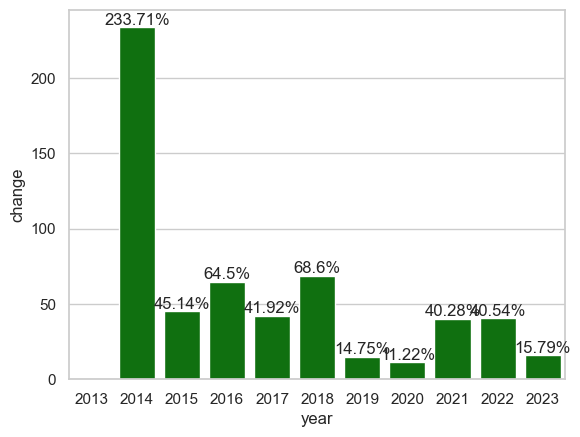

In [13]:
#Check % of revenue change by years
sns.set_theme(style="whitegrid")
ax = sns.barplot(x='year', y='change', data = year_change, color = 'green')
for index, row in year_change.iterrows():
    ax.text(row.name, row.change, str(row.change)+'%', ha="center", fontsize=12, va='bottom')

## Создать флаги по типу дохода (stationary, delivery, ...)

In [14]:
#merge with info df
branches = pd.merge(branches_info, branches_revenue, how='inner', on='id').drop('Unnamed: 0', axis=1)
branches['startDate'] = pd.to_datetime(branches['startDate'])
branches[pd.DatetimeIndex(branches['startDate']).year > 2012]
#create index of first 12 months of work of the branch
branches['start_indx'] = branches.groupby('id').cumcount()

In [15]:
##grouping by start_indx
revenue_by_index = branches.groupby('start_indx')['revenue'].mean().reset_index()
revenue_by_index = revenue_by_index[revenue_by_index['start_indx']<60]

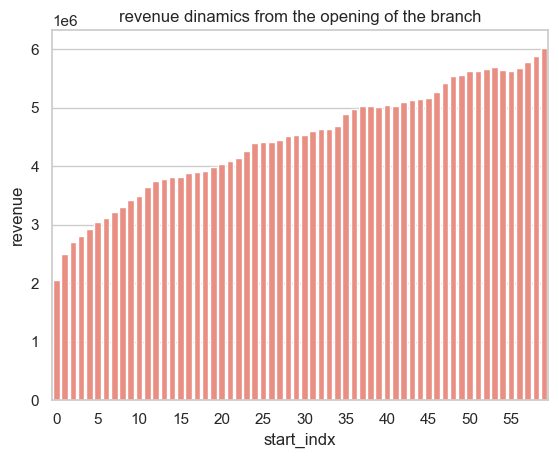

<Figure size 800x600 with 0 Axes>

In [16]:
# Set the style and context for the plot
sns.set_theme(style="whitegrid")
ax = sns.barplot(x='start_indx', y='revenue', data=revenue_by_index, color='salmon')

n = 5  # Show every 5th tick label
xticks = ax.get_xticks()
ax.set_xticks(xticks[::n])
ax.set_title('revenue dinamics from the opening of the branch')
plt.figure(figsize=(8, 6))

plt.show()

### Inflation correction

In [17]:
inflation['inf_disc'] = 1 / (1 + inflation['inflation_rate'] / 100).cumprod()
inflation['value_2022'] = 100 * inflation['inf_disc']

In [18]:
inflation = inflation[['year', 'inf_disc']]

In [19]:
branches = pd.merge(branches, inflation, how='inner', on='year')

In [20]:
branches = branches.rename(columns={'inf_disc': 'inflation_rate'})

In [21]:
branches['revenue_in_2023'] = branches['revenue'] / branches['inflation_rate']

In [22]:
branches.head(5)

id         name             alias  startDate  \
0   3  Сыктывкар-1  Первомайская, 85 2011-10-06   
1   3  Сыктывкар-1  Первомайская, 85 2011-10-06   
2   3  Сыктывкар-1  Первомайская, 85 2011-10-06   
3   3  Сыктывкар-1  Первомайская, 85 2011-10-06   
4   3  Сыктывкар-1  Первомайская, 85 2011-10-06   

                                coords       city  year  month    revenue  \
0  {'lat': 61.66572, 'long': 50.83164}  Сыктывкар  2013      2  5518897.0   
1  {'lat': 61.66572, 'long': 50.83164}  Сыктывкар  2013      3  6119627.0   
2  {'lat': 61.66572, 'long': 50.83164}  Сыктывкар  2013      4  5157385.0   
3  {'lat': 61.66572, 'long': 50.83164}  Сыктывкар  2013      5  5460128.0   
4  {'lat': 61.66572, 'long': 50.83164}  Сыктывкар  2013      6  5777048.0   

   stationaryRevenue  deliveryRevenue  pickupRevenue  start_indx  \
0          2330597.0        3145783.0        42517.0           0   
1          2444287.0        3623147.0        52193.0           1   
2          2290944.0        2824971.0        41470.0           2   
3          2445363.0        2976970.0        37795.0           3   
4          2496108.0        3231975.0        48965.0           4   

   inflation_rate  revenue_in_2023  
0        0.505714     1.091309e+07  
1        0.505714     1.210097e+07  
2        0.505714     1.019823e+07  
3        0.505714     1.079688e+07  
4        0.505714     1.142355e+07

/var/folders/pd/fjb9sj5x6t3dnxtpzxxzkv6c0000gn/T/ipykernel_31381/2080881080.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  revenue_by_index = branches.groupby('start_indx')['revenue_in_2023', 'revenue'].mean().reset_index()


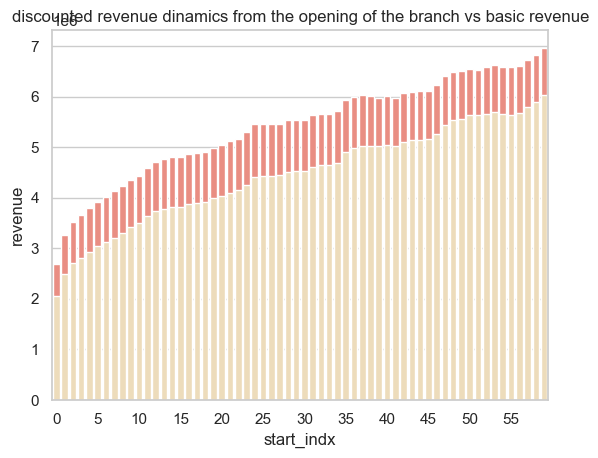

In [23]:
##grouping by start_indx
revenue_by_index = branches.groupby('start_indx')['revenue_in_2023', 'revenue'].mean().reset_index()
revenue_by_index = revenue_by_index[revenue_by_index['start_indx']<60]

# Set the style and context for the plot
sns.set_theme(style="whitegrid")
ax1 = sns.barplot(x='start_indx', y='revenue_in_2023', data=revenue_by_index, color='salmon')
ax2 = sns.barplot(x='start_indx', y='revenue', data=revenue_by_index, color='wheat')
n = 5  # Show every 5th tick label
xticks = ax1.get_xticks()
ax1.set_xticks(xticks[::n])
ax1.set_title('discounted revenue dinamics from the opening of the branch vs basic revenue')
plt.show()

#### Merging cities info with df

In [24]:
cities_info = cities_info.drop('Region', axis=1)

In [25]:
branches = pd.merge(branches, cities_info, left_on='city',right_on='City', how='left')

## Plot scatter for all dodo to check seasonability

In [26]:
branches['dttm'] = pd.to_datetime(branches[['year', 'month']].assign(day=1))

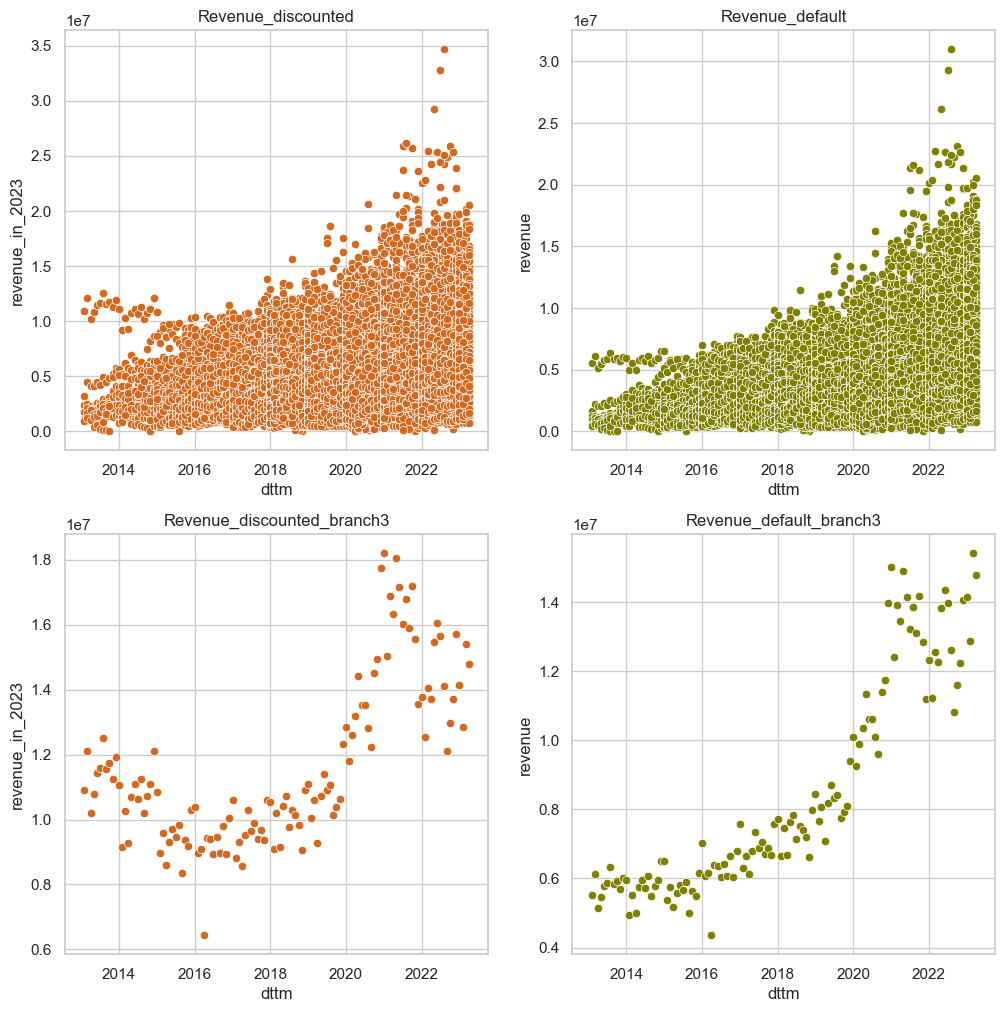

In [27]:
#plot graphs with corrected revenue and default revenue to check dynamics of branches
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

sns.scatterplot(data=branches, x='dttm', y='revenue_in_2023', ax=ax[0,0], color='chocolate')
sns.scatterplot(data=branches, x='dttm', y='revenue', ax=ax[0,1], color='olive')
sns.scatterplot(data=branches[branches['id']==3], x='dttm', y='revenue_in_2023', ax=ax[1,0], color='chocolate')
sns.scatterplot(data=branches[branches['id']==3], x='dttm', y='revenue', ax=ax[1,1], color='olive')

ax[0,0].set_title('Revenue_discounted')
ax[0,1].set_title('Revenue_default')
ax[1,0].set_title('Revenue_discounted_branch3')
ax[1,1].set_title('Revenue_default_branch3')
plt.show()


There is no seasonability in the revenue

Let's create dataset with only revenue for 1 year

In [28]:
df = branches[(branches['start_indx']<=11)&(branches['startDate'].dt.year >=2013)]

Text(0.5, 1.0, 'Revenue default on df for 1st year branch3')

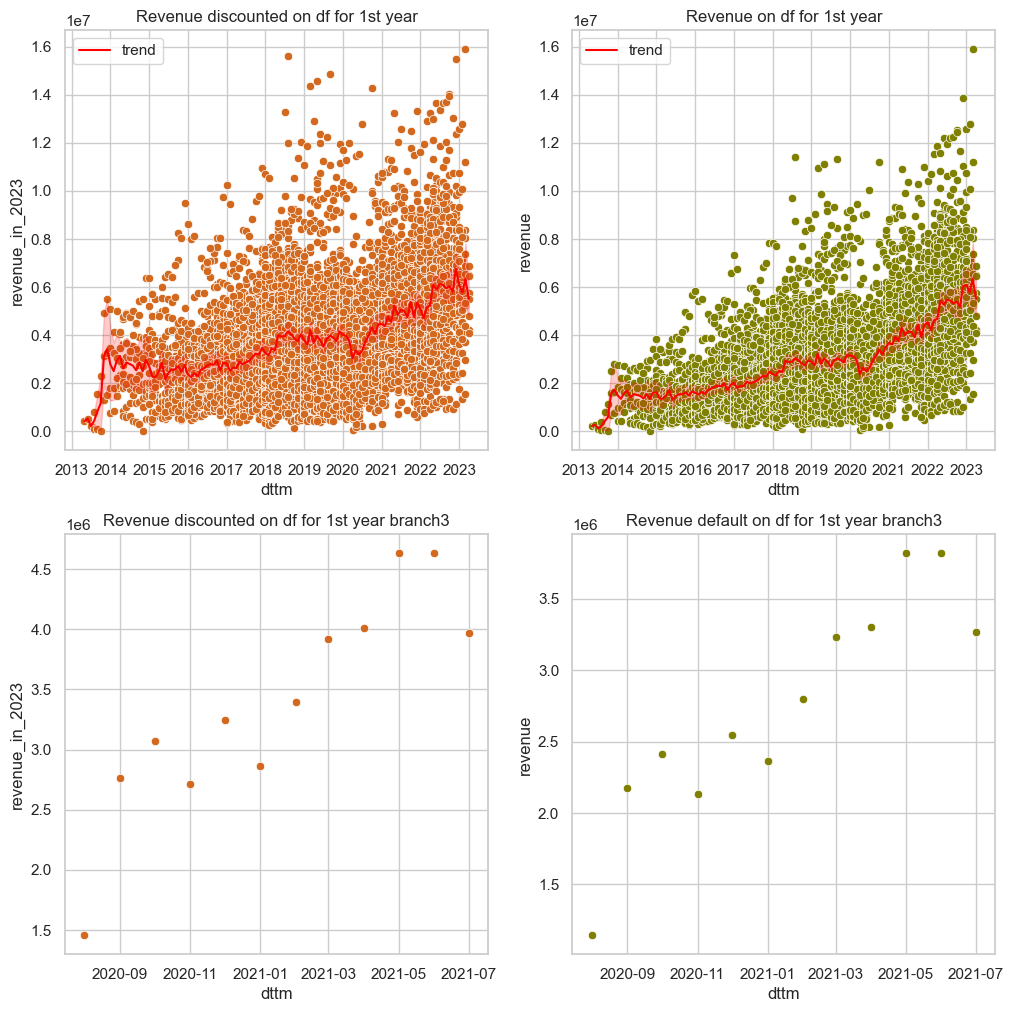

In [29]:
#check the same for the first year of pizzerias
ig, ax = plt.subplots(2, 2, figsize=(12, 12))

sns.scatterplot(data=df, x='dttm', y='revenue_in_2023', ax=ax[0,0], color='chocolate')
sns.lineplot(data=df, x='dttm', y='revenue_in_2023', ax=ax[0,0], color='red', label='trend')
sns.scatterplot(data=df, x='dttm', y='revenue', ax=ax[0,1], color='olive')
sns.scatterplot(data=df[df['id']==1100], x='dttm', y='revenue_in_2023', ax=ax[1,0], color='chocolate')
sns.lineplot(data=df, x='dttm', y='revenue', ax=ax[0,1], color='red', label='trend')
sns.scatterplot(data=df[df['id']==1100], x='dttm', y='revenue', ax=ax[1,1], color='olive')

ax[0,0].set_title('Revenue discounted on df for 1st year')
ax[0,1].set_title('Revenue on df for 1st year')
ax[1,0].set_title('Revenue discounted on df for 1st year branch3')
ax[1,1].set_title('Revenue default on df for 1st year branch3')

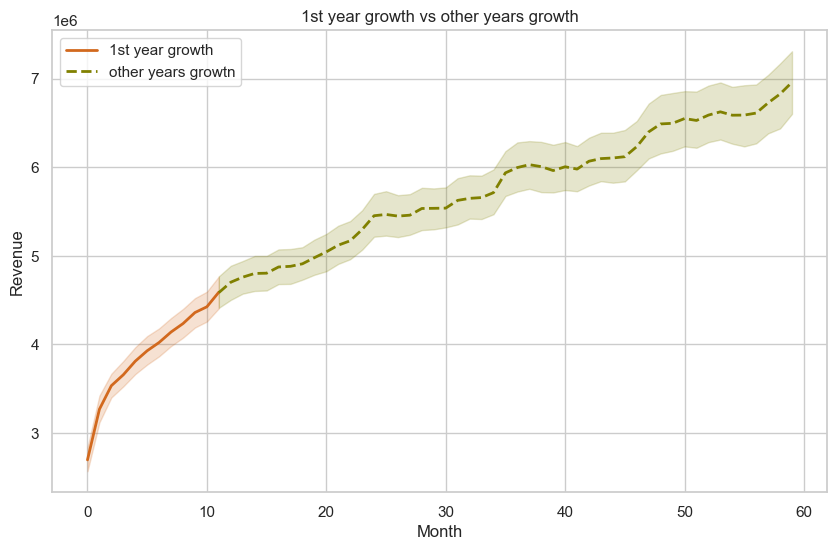

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=df, x='start_indx', y='revenue_in_2023', color='chocolate', label='1st year growth', linewidth=2)
sns.lineplot(data=branches[(branches['start_indx'] >= 11) & (branches['start_indx'] < 60)], x='start_indx', y='revenue_in_2023', color='olive', label='other years growtn', linewidth=2, linestyle='--')

plt.grid(True)

plt.legend()

plt.xlabel('Month')
plt.ylabel('Revenue')
plt.title('1st year growth vs other years growth')

plt.show()


<AxesSubplot:ylabel='revenue_in_2023'>

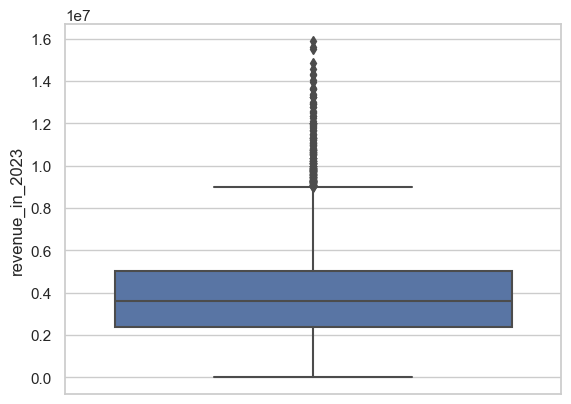

In [31]:
sns.boxplot(data = df, y='revenue_in_2023')

Remove outliers

In [32]:
id_to_remove = df[df['revenue_in_2023']>=df['revenue_in_2023'].quantile(.97)]['id']

In [33]:
len(id_to_remove.unique())

48

In [34]:
df = df[~df['id'].isin(id_to_remove)]

In [35]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7188 entries, 88 to 35379
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 7188 non-null   int64         
 1   name               7188 non-null   object        
 2   alias              7188 non-null   object        
 3   startDate          7188 non-null   datetime64[ns]
 4   coords             7188 non-null   object        
 5   city               7188 non-null   object        
 6   year               7188 non-null   int64         
 7   month              7188 non-null   int64         
 8   revenue            7188 non-null   float64       
 9   stationaryRevenue  7188 non-null   float64       
 10  deliveryRevenue    7188 non-null   float64       
 11  pickupRevenue      7188 non-null   float64       
 12  start_indx         7188 non-null   int64         
 13  inflation_rate     7188 non-null   float64       
 14  revenu

Text(0.5, 1.0, 'Default revenue distribution')

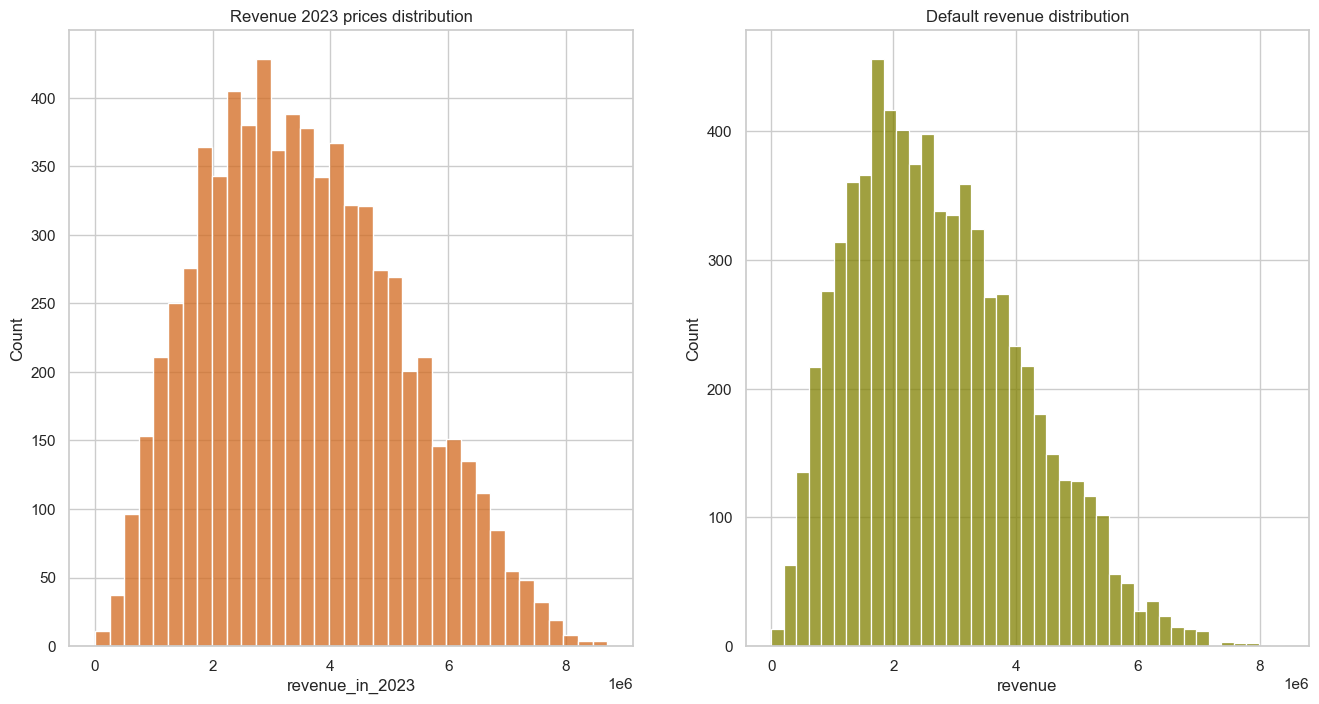

In [36]:
#distributioin of revenue
fig, ax = plt.subplots(1,2, figsize=(16,8))
sns.histplot(data=df, x=df['revenue_in_2023'], ax=ax[0], color="chocolate")
sns.histplot(data=df, x='revenue', ax=ax[1], color="olive")
ax[0].set_title('Revenue 2023 prices distribution')
ax[1].set_title('Default revenue distribution')


### Creating new features

In [37]:
#create_season_features
df['quarter'] = df['dttm'].dt.quarter

In [38]:
df['quarter'].value_counts()

1    1817
4    1804
3    1799
2    1768
Name: quarter, dtype: int64

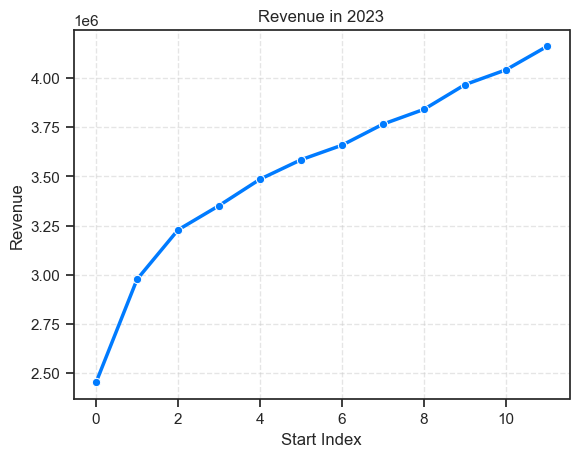

In [39]:
#check revenue dynamics during first year of a work
colors = ['#007bff']

data = df.groupby('start_indx')['revenue_in_2023'].mean().reset_index()
sns.set(style='ticks', palette=colors)
sns.lineplot(x='start_indx', y='revenue_in_2023', data=data, linewidth=2.5, marker='o')

plt.title('Revenue in 2023')
plt.xlabel('Start Index')
plt.ylabel('Revenue')

plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

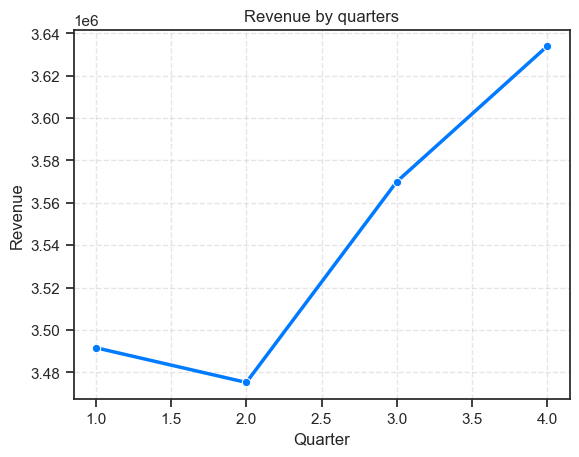

In [40]:
#check seasonability 
colors = ['#007bff']

data = df.groupby('quarter')['revenue_in_2023'].mean().reset_index()
sns.set(style='ticks', palette=colors)
sns.lineplot(x='quarter', y='revenue_in_2023', data=data, linewidth=2.5, marker='o')

plt.title('Revenue by quarters')
plt.xlabel('Quarter')
plt.ylabel('Revenue')

plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

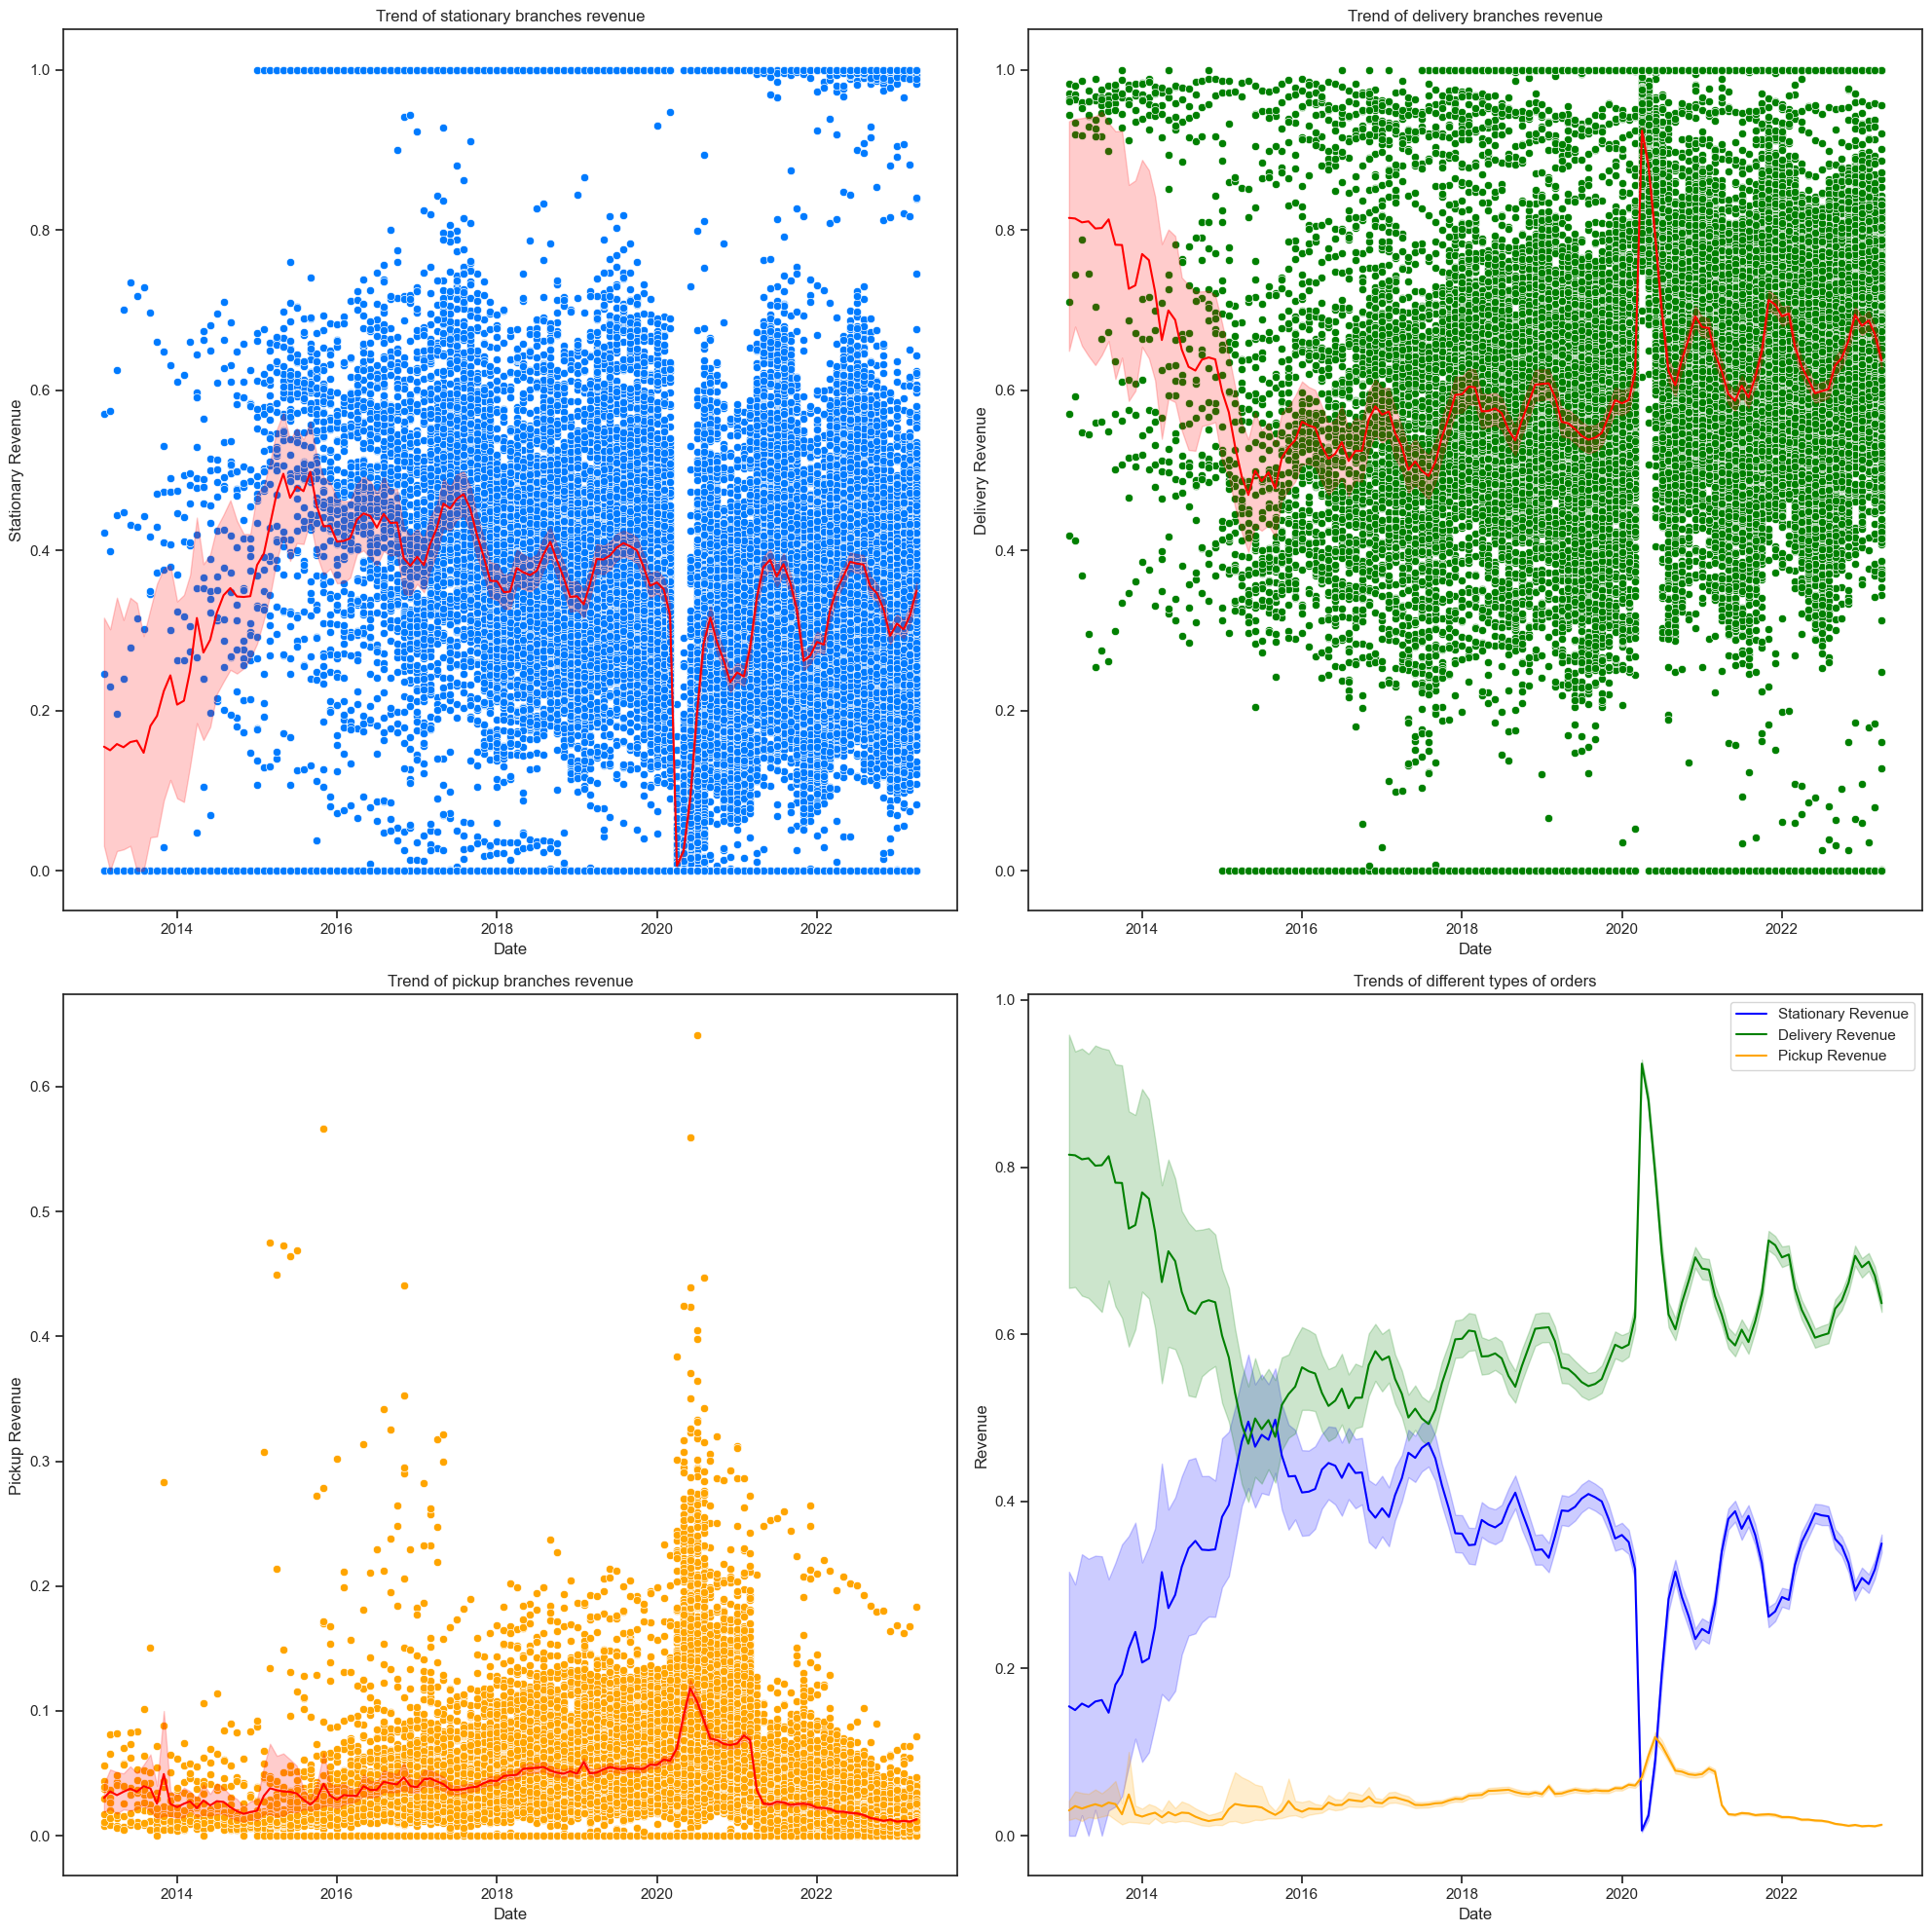

In [41]:
#check dynamics of different types of orders by time
fig, ax = plt.subplots(2, 2, figsize=(20, 20))

sns.scatterplot(x='dttm', y=branches['stationaryRevenue'] / branches['revenue'], data=branches, marker='o', ax=ax[0, 0])
sns.lineplot(x='dttm', y=branches['stationaryRevenue'] / branches['revenue'], data=branches, color='red', ax=ax[0, 0])

sns.scatterplot(x='dttm', y=branches['deliveryRevenue'] / branches['revenue'], data=branches, marker='o', ax=ax[0, 1], color='green')
sns.lineplot(x='dttm', y=branches['deliveryRevenue'] / branches['revenue'], data=branches, color='red', ax=ax[0, 1])

sns.scatterplot(x='dttm', y=branches['pickupRevenue'] / branches['revenue'], data=branches, marker='o', ax=ax[1, 0], color='orange')
sns.lineplot(x='dttm', y=branches['pickupRevenue'] / branches['revenue'], data=branches, color='red', ax=ax[1, 0])

sns.lineplot(x='dttm', y=branches['stationaryRevenue'] / branches['revenue'], data=branches, color='blue', ax=ax[1, 1], label='Stationary Revenue')
sns.lineplot(x='dttm', y=branches['deliveryRevenue'] / branches['revenue'], data=branches, color='green', ax=ax[1, 1], label='Delivery Revenue')
sns.lineplot(x='dttm', y=branches['pickupRevenue'] / branches['revenue'], data=branches, color='orange', ax=ax[1, 1], label='Pickup Revenue')


ax[0, 0].set_title('Trend of stationary branches revenue')
ax[0, 0].set_xlabel('Date')
ax[0, 0].set_ylabel('Stationary Revenue')

ax[0, 1].set_title('Trend of delivery branches revenue')
ax[0, 1].set_xlabel('Date')
ax[0, 1].set_ylabel('Delivery Revenue')

ax[1, 0].set_title('Trend of pickup branches revenue')
ax[1, 0].set_xlabel('Date')
ax[1, 0].set_ylabel('Pickup Revenue')

ax[1, 1].set_title('Trends of different types of orders')
ax[1, 1].set_xlabel('Date')
ax[1, 1].set_ylabel('Revenue')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

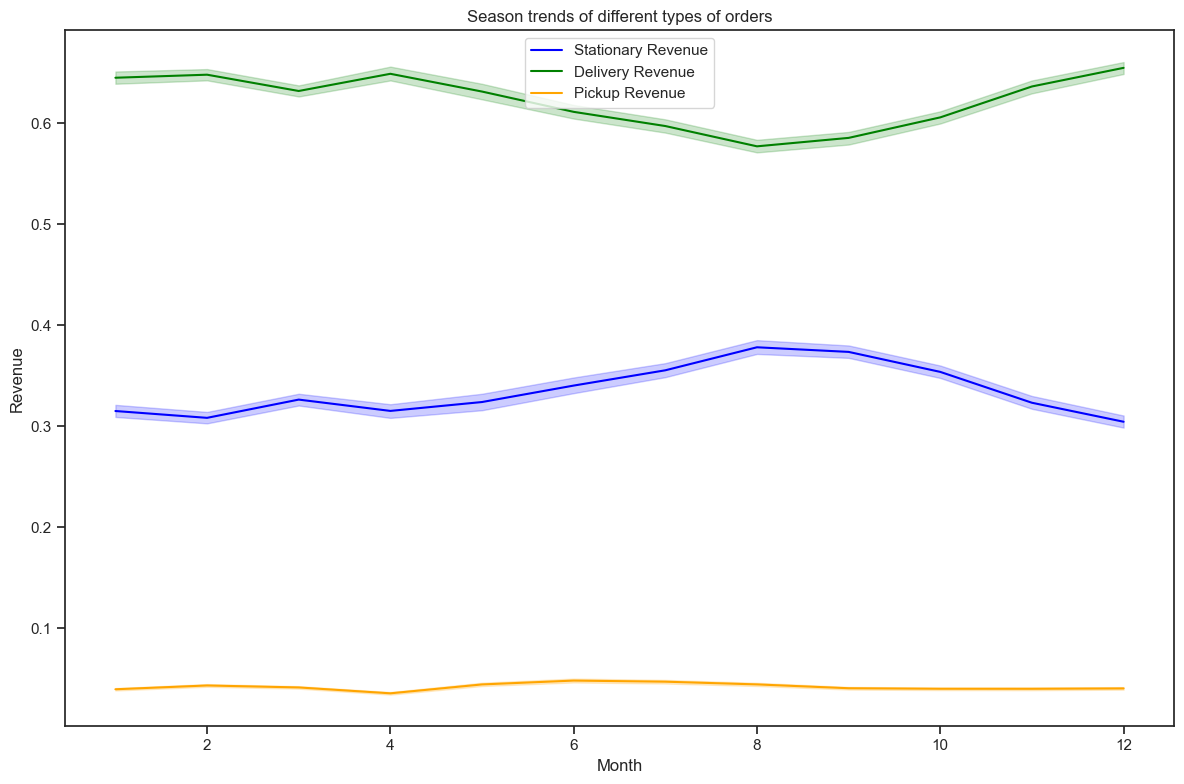

In [42]:
#check dynamics of different types of orders by time
fig, ax = plt.subplots(1,1, figsize=(12, 8))

sns.lineplot(x='month', y=branches['stationaryRevenue'] / branches['revenue'], data=branches, color='blue', label='Stationary Revenue')
sns.lineplot(x='month', y=branches['deliveryRevenue'] / branches['revenue'], data=branches, color='green', label='Delivery Revenue')
sns.lineplot(x='month', y=branches['pickupRevenue'] / branches['revenue'], data=branches, color='orange', label='Pickup Revenue')

ax.set_title('Season trends of different types of orders')
ax.set_xlabel('Month')
ax.set_ylabel('Revenue')
ax.legend()

plt.tight_layout()
plt.show()

### Preparing for split

In [43]:
df.columns

Index(['id', 'name', 'alias', 'startDate', 'coords', 'city', 'year', 'month',
       'revenue', 'stationaryRevenue', 'deliveryRevenue', 'pickupRevenue',
       'start_indx', 'inflation_rate', 'revenue_in_2023', 'City',
       'Average_income', 'me_mln_flag', '500k-mln_flag', '250k-500k_flag',
       '100k-250k_flag', 'lt_100k_flag', 'dttm', 'quarter'],
      dtype='object')

In [44]:
location_info.columns

Index(['Unnamed: 0', 'id', 'name', 'alias', 'startDate', 'coords', 'city',
       'apartments_lt_5lvl', 'apartments_me_5lvl_lt_10lvl',
       'apartments_me_10lvl_lt_15lvl', 'apartments_me_15lvl', 'dormitory',
       'hotel', 'residential', 'commercial', 'office', 'retail', 'civic',
       'college', 'school', 'transportation', 'university', 'stadium',
       'sports_hall', 'pavilion', 'adult_gaming_centre', 'fitness_centre',
       'park', 'sauna', 'hackerspace', 'bar', 'fast_food', 'cafe',
       'food_court', 'restaurant', 'cinema', 'exhibition_centre', 'attraction',
       'gallery', 'museum', 'zoo', 'yes', 'picnic_site'],
      dtype='object')

Let's check correlation between main features

In [45]:
#merge with location info
df = pd.merge(df, location_info.drop(['Unnamed: 0', 'name', 'alias', 'startDate', 'coords', 'city'], axis=1), on='id', how='left')

In [46]:
df['quarter'].value_counts()

1    1817
4    1804
3    1799
2    1768
Name: quarter, dtype: int64

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7188 entries, 0 to 7187
Data columns (total 60 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id                            7188 non-null   int64         
 1   name                          7188 non-null   object        
 2   alias                         7188 non-null   object        
 3   startDate                     7188 non-null   datetime64[ns]
 4   coords                        7188 non-null   object        
 5   city                          7188 non-null   object        
 6   year                          7188 non-null   int64         
 7   month                         7188 non-null   int64         
 8   revenue                       7188 non-null   float64       
 9   stationaryRevenue             7188 non-null   float64       
 10  deliveryRevenue               7188 non-null   float64       
 11  pickupRevenue                 

In [48]:
#возможно удалить civic и apartments
TRAIN_COLUMNS = ['year', 'month', 'start_indx', 'Average_income', 'me_mln_flag', '500k-mln_flag', '250k-500k_flag', 
                 '100k-250k_flag', 'lt_100k_flag', 'quarter']

LOCATION_COLUMNS_TRAIN = ['dormitory', 'hotel', 'residential', 'commercial',
       'office', 'retail', 'civic', 'school', 'transportation',
       'fast_food', 'cafe', 'food_court', 'restaurant',
       'exhibition_centre', 'leisure', 'tourism', 'mid_high_education']
       
TARGET = 'revenue_in_2023'
SCALE_COLUMNS = ['month','start_indx', 'Average_income', 'me_mln_flag', '500k-mln_flag', '250k-500k_flag', 
                 '100k-250k_flag', 'lt_100k_flag', 'quarter']
test_cols = ['apartments_lt_5lvl', 'apartments_me_5lvl_lt_10lvl', 'apartments_me_10lvl_lt_15lvl',
       'apartments_me_15lvl','stationary_flag','delivery_flag']

- Sum some of the columns
- Create new corr matrix only with location_info

In [49]:
#sum some columns
df['leisure'] = df['adult_gaming_centre'] + df['fitness_centre'] + df['park'] + df['sauna'] + df['hackerspace']+df['cinema']
df['tourism'] = df['attraction'] + df['gallery'] + df['museum'] + df['zoo'] + df['picnic_site']
df['mid_high_education'] = df['college'] + df['university']
df['civic'] = df['civic'] + df['transportation']
df['delivery_flag'] = df.apply(lambda x: int(x['deliveryRevenue'] > x['stationaryRevenue']), axis=1)
df['stationary_flag'] = df.apply(lambda x: int(x['deliveryRevenue']<=x['stationaryRevenue']), axis=1)

In [50]:
df['start_indx'] = df['start_indx'] + 1
df['month'] = df['month'] + 1

correlation checking 

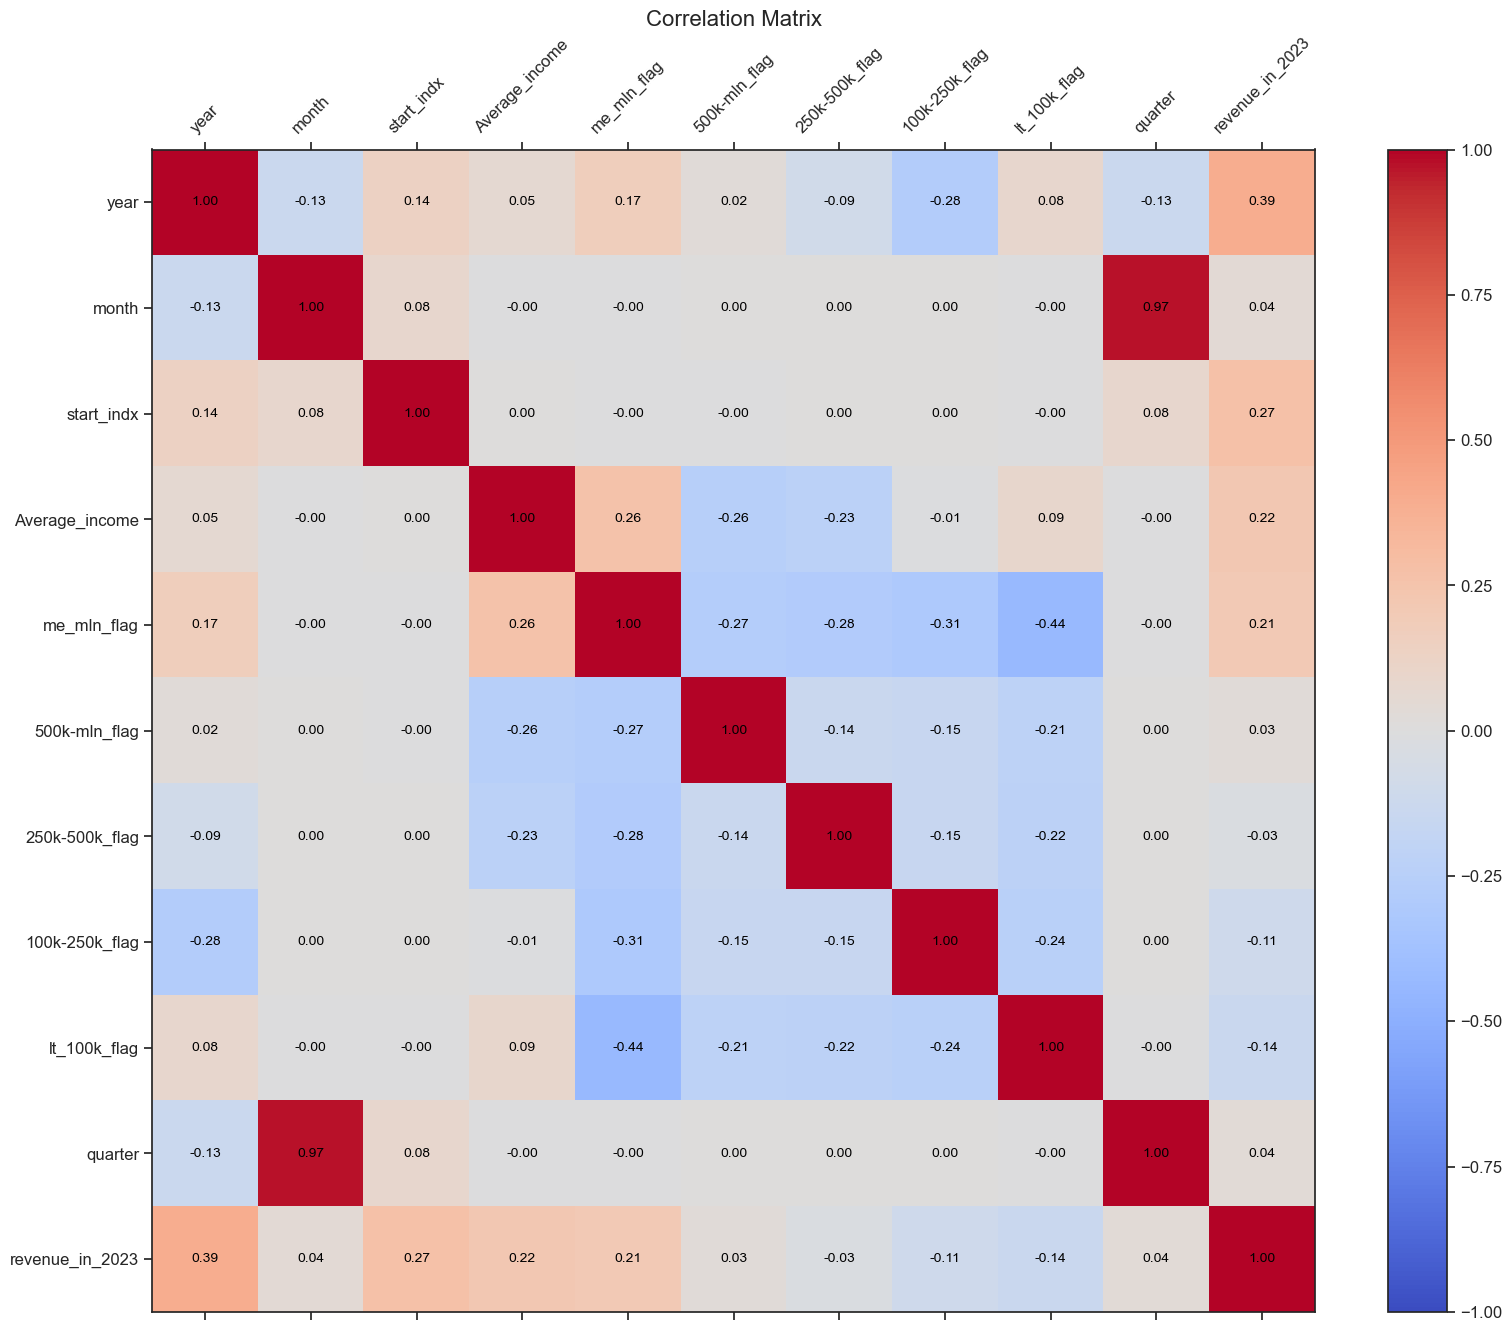

In [51]:
corr_matrix = df[TRAIN_COLUMNS+[TARGET]].select_dtypes(include=[np.number]).corr()


f = plt.figure(figsize=(19, 15))
plt.matshow(corr_matrix, fignum=f.number, cmap='coolwarm', vmin=-1, vmax=1)
plt.xticks(range(corr_matrix.shape[1]), corr_matrix.columns, fontsize=12, rotation=45)
plt.yticks(range(corr_matrix.shape[1]), corr_matrix.columns, fontsize=12)

for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[1]):
        plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", ha="center", va="center", color="black", fontsize=10)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)

plt.title('Correlation Matrix', fontsize=16)

plt.show()

In [52]:
for_matrix_df = df[LOCATION_COLUMNS_TRAIN + [TARGET]]

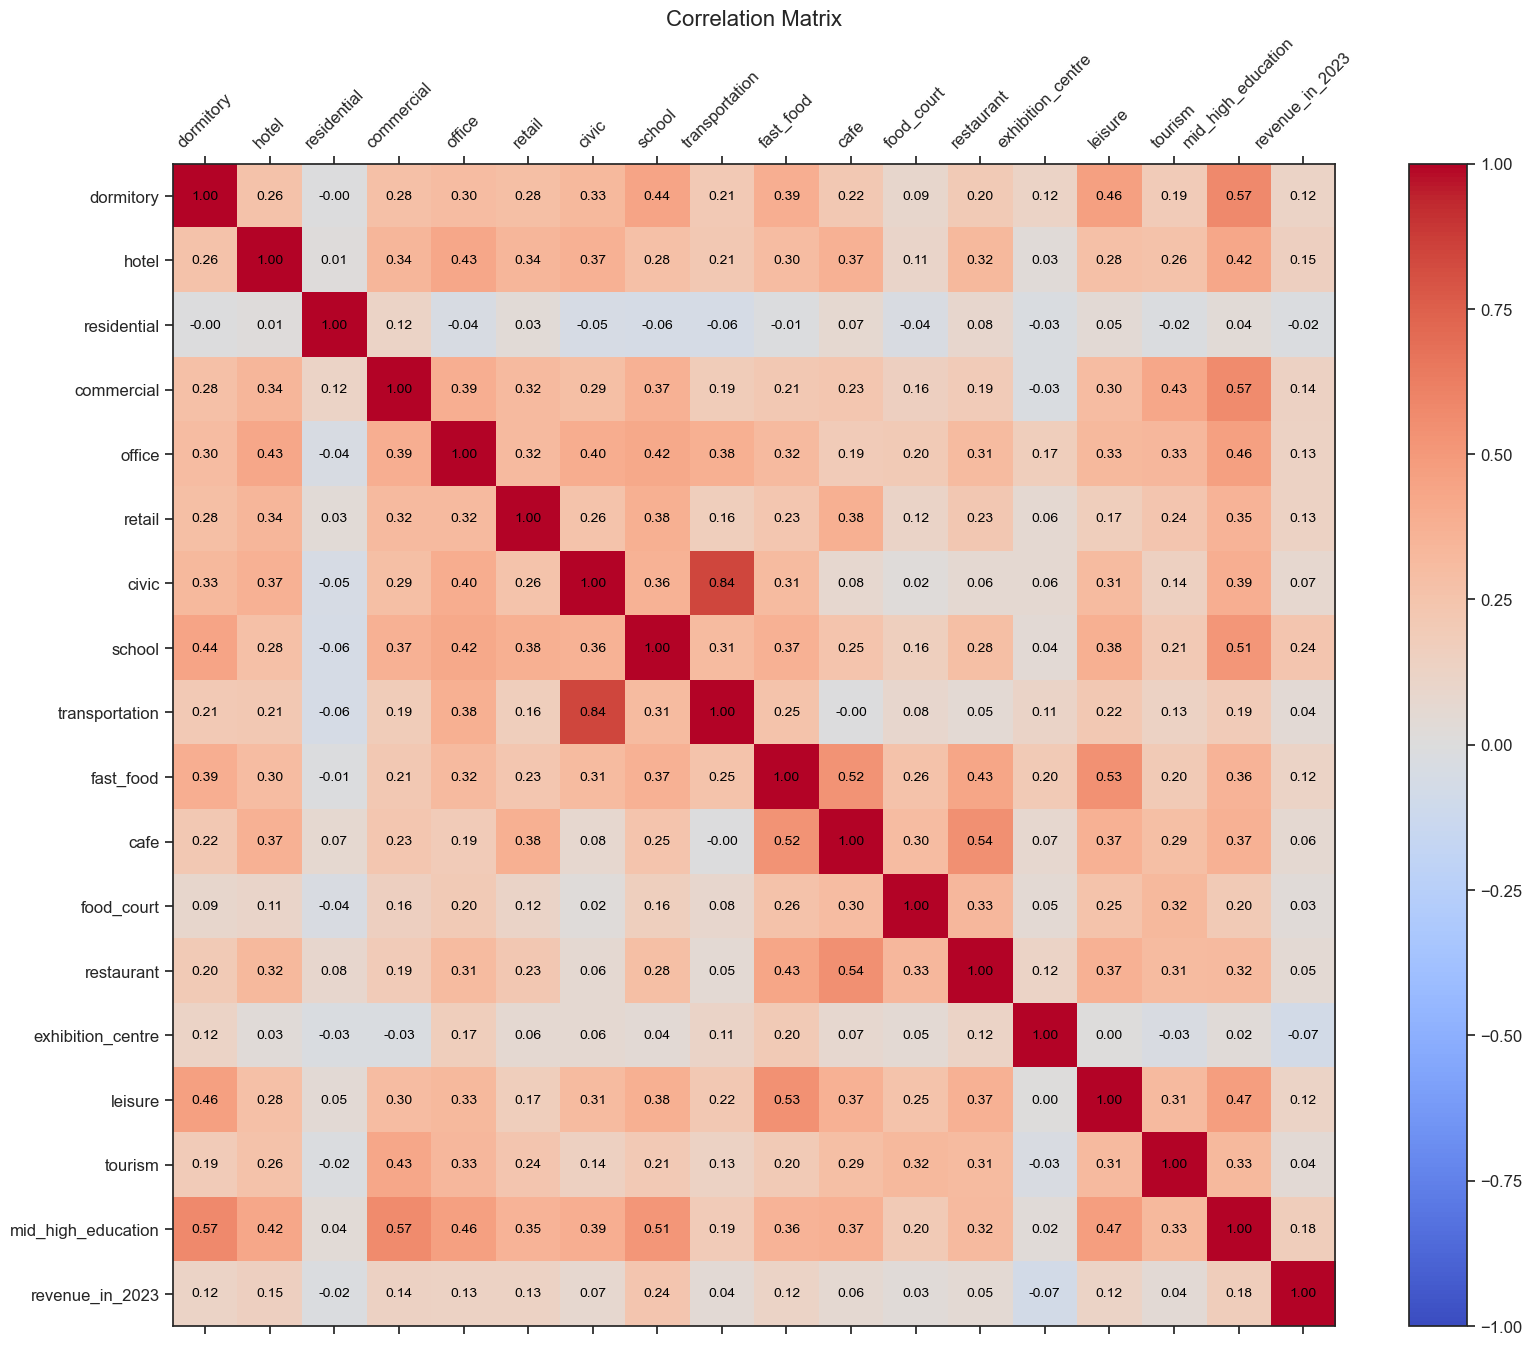

In [53]:
corr_matrix = for_matrix_df.select_dtypes(include=[np.number]).corr()


f = plt.figure(figsize=(19, 15))
plt.matshow(corr_matrix, fignum=f.number, cmap='coolwarm', vmin=-1, vmax=1)
plt.xticks(range(corr_matrix.shape[1]), corr_matrix.columns, fontsize=12, rotation=45)
plt.yticks(range(corr_matrix.shape[1]), corr_matrix.columns, fontsize=12)

for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[1]):
        plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", ha="center", va="center", color="black", fontsize=10)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)

plt.title('Correlation Matrix', fontsize=16)

plt.show()

TRAIN TEST SPLIT

In [54]:
X = df[TRAIN_COLUMNS + LOCATION_COLUMNS_TRAIN]
y = df[TARGET]

In [55]:
year = pd.get_dummies(X['year'])
X = pd.concat([X, year], axis=1)
X.drop('year', axis=1, inplace=True)

In [56]:
# scale features
scaler = MinMaxScaler()

scaler.fit(X[SCALE_COLUMNS + LOCATION_COLUMNS_TRAIN])
X[SCALE_COLUMNS + LOCATION_COLUMNS_TRAIN] = scaler.transform(X[SCALE_COLUMNS + LOCATION_COLUMNS_TRAIN])

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, random_state=43)

In [58]:
X_train.head(20)

month  start_indx  Average_income  me_mln_flag  500k-mln_flag  \
2584  0.818182    0.818182        0.346454          0.0            0.0   
6329  0.363636    0.000000        0.104566          0.0            1.0   
6767  0.454545    0.454545        0.384909          0.0            0.0   
5858  0.000000    0.545455        0.384909          1.0            0.0   
1349  0.272727    0.727273        0.170524          0.0            0.0   
5940  0.000000    0.727273        0.528507          1.0            0.0   
4890  0.181818    0.727273        0.055356          0.0            0.0   
2878  0.272727    0.181818        0.061562          0.0            0.0   
5805  1.000000    0.909091        0.384909          1.0            0.0   
5446  0.818182    0.727273        0.528507          0.0            0.0   
4097  0.545455    0.545455        0.104566          0.0            1.0   
941   0.545455    0.090909        0.281824          0.0            1.0   
90    0.363636    0.000000        0.194229          0.0            0.0   
4179  0.181818    0.272727        0.094024          1.0            0.0   
6332  0.636364    0.272727        0.104566          0.0            1.0   
6048  0.272727    0.545455        0.344561          1.0            0.0   
6671  0.636364    0.545455        0.115896          1.0            0.0   
3058  0.454545    0.272727        0.157901          0.0            0.0   
786   0.818182    0.454545        0.143609          0.0            0.0   
4677  0.090909    0.818182        0.071646          0.0            0.0   

      250k-500k_flag  100k-250k_flag  lt_100k_flag   quarter  dormitory  ...  \
2584             0.0             0.0           1.0  1.000000   0.000000  ...   
6329             0.0             0.0           0.0  0.333333   0.142857  ...   
6767             0.0             0.0           1.0  0.333333   0.000000  ...   
5858             0.0             0.0           0.0  0.000000   0.160714  ...   
1349             0.0             0.0           1.0  0.333333   0.000000  ...   
5940             0.0             0.0           0.0  0.000000   0.035714  ...   
4890             0.0             0.0           1.0  0.000000   0.017857  ...   
2878             0.0             0.0           1.0  0.333333   0.000000  ...   
5805             0.0             0.0           0.0  1.000000   0.500000  ...   
5446             0.0             0.0           1.0  1.000000   0.000000  ...   
4097             0.0             0.0           0.0  0.666667   0.035714  ...   
941              0.0             0.0           0.0  0.666667   0.053571  ...   
90               0.0             1.0           0.0  0.333333   0.107143  ...   
4179             0.0             0.0           0.0  0.000000   0.053571  ...   
6332             0.0             0.0           0.0  0.666667   0.142857  ...   
6048             0.0             0.0           0.0  0.333333   0.250000  ...   
6671             0.0             0.0           0.0  0.666667   0.196429  ...   
3058             1.0             0.0           0.0  0.333333   0.250000  ...   
786              0.0             0.0           1.0  1.000000   0.000000  ...   
4677             0.0             0.0           1.0  0.000000   0.071429  ...   

      2014  2015  2016  2017  2018  2019  2020  2021  2022  2023  
2584     0     0     0     0     1     0     0     0     0     0  
6329     0     0     0     0     0     0     0     1     0     0  
6767     0     0     0     0     0     0     0     0     1     0  
5858     0     0     0     0     0     0     0     1     0     0  
1349     0     0     0     1     0     0     0     0     0     0  
5940     0     0     0     0     0     0     0     1     0     0  
4890     0     0     0     0     0     0     1     0     0     0  
2878     0     0     0     0     1     0     0     0     0     0  
5805     0     0     0     0     0     0     0     1     0     0  
5446     0     0     0     0     0     0     1     0     0     0  
4097     0     0     0     0     0  

In [59]:
list(X_train.columns)

['month',
 'start_indx',
 'Average_income',
 'me_mln_flag',
 '500k-mln_flag',
 '250k-500k_flag',
 '100k-250k_flag',
 'lt_100k_flag',
 'quarter',
 'dormitory',
 'hotel',
 'residential',
 'commercial',
 'office',
 'retail',
 'civic',
 'school',
 'transportation',
 'fast_food',
 'cafe',
 'food_court',
 'restaurant',
 'exhibition_centre',
 'leisure',
 'tourism',
 'mid_high_education',
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022,
 2023]

In [60]:
# profile = ProfileReport(X_train)
# profile.to_file('profile.html')

In [61]:
def evaluation(test_pred, train_pred, name)->pd.DataFrame:

    test_mae = mean_absolute_error(y_test, test_pred)
    train_mae = mean_absolute_error(y_train, train_pred)
    
    test_mape = mean_absolute_percentage_error(y_test, test_pred)
    train_mape = mean_absolute_percentage_error(y_train, train_pred)

    test_mse = mean_squared_error(y_test, test_pred)
    train_mse = mean_squared_error(y_train, train_pred)

    test_r2 = r2_score(y_test, test_pred)
    train_r2 = r2_score(y_train, train_pred)


    df = pd.DataFrame({
        'model' : [name+'_test', name+'_train'],
        'mae' : [test_mae, train_mae],
        'mse' : [test_mse, train_mse],
        'mape' : [test_mape, train_mape],
        'R^2' : [test_r2, train_r2]
        })

    return df

## Regressions

In [62]:
print(X_train.shape)
print(X_test.shape)

(5031, 37)
(2157, 37)


In [63]:
params = {
    'alpha' : [0.01, 0.01, 1, 10, 30],
}

lasso = GridSearchCV(
    Lasso(),
    params,
    scoring = 'neg_mean_squared_error'
)

lasso.fit(X_train, y_train)

train_lasso = lasso.predict(X_train)
test_lasso = lasso.predict(X_test)
print("Best parameters:", lasso.best_params_)
results = evaluation(test_lasso, train_lasso, 'lasso')
results

/Users/nikitasenyatkin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/nikitasenyatkin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.258e+13, tolerance: 1.098e+12
  model = cd_fast.enet_coordinate_descent(
/Users/nikitasenyatkin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/nikitasenyatkin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:168

Best parameters: {'alpha': 30}


/Users/nikitasenyatkin/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.203e+14, tolerance: 1.368e+12
  model = cd_fast.enet_coordinate_descent(
/Users/nikitasenyatkin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/nikitasenyatkin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


model           mae           mse      mape       R^2
0   lasso_test  1.031537e+06  1.713662e+12  0.491492  0.359661
1  lasso_train  1.043705e+06  1.739872e+12  0.869976  0.360276

In [64]:
params = {
    'alpha' : [0.01, 0.01, 1, 10, 30],
    'solver' : ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
}

ridge = GridSearchCV(
    Ridge(),
    params,
    scoring = 'neg_mean_squared_error'
)

ridge.fit(X_train, y_train)

train_ridge = ridge.predict(X_train)
test_ridge = ridge.predict(X_test)
print("Best parameters:", lasso.best_params_)
results = pd.concat([results, evaluation(test_ridge, train_ridge, 'ridge')], axis=0)
results

/Users/nikitasenyatkin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/nikitasenyatkin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/nikitasenyatkin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/nikitasenyatkin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int

Best parameters: {'alpha': 30}


/Users/nikitasenyatkin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/nikitasenyatkin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


model           mae           mse      mape       R^2
0   lasso_test  1.031537e+06  1.713662e+12  0.491492  0.359661
1  lasso_train  1.043705e+06  1.739872e+12  0.869976  0.360276
0   ridge_test  1.031493e+06  1.713389e+12  0.492370  0.359763
1  ridge_train  1.043826e+06  1.740001e+12  0.872585  0.360228

## Gradient boosting

In [65]:
cbr = CatBoostRegressor(
    loss_function='RMSE',
    early_stopping_rounds=100
)

cbr.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    plot=True
)


cbr.fit(X_train, y_train, eval_set=(X_test, y_test))
train_cbr = cbr.predict(X_train)
test_cbr = cbr.predict(X_test)
results = pd.concat([results, evaluation(test_cbr, train_cbr, 'cbr_basic')], axis=0)
results

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.065623
0:	learn: 1623853.5735748	test: 1610571.5694997	best: 1610571.5694997 (0)	total: 59.7ms	remaining: 59.7s
1:	learn: 1600503.1814974	test: 1587952.6817851	best: 1587952.6817851 (1)	total: 61.2ms	remaining: 30.5s
2:	learn: 1578554.5290226	test: 1566028.6850527	best: 1566028.6850527 (2)	total: 62.4ms	remaining: 20.7s
3:	learn: 1557821.5338201	test: 1545846.0597873	best: 1545846.0597873 (3)	total: 63.7ms	remaining: 15.9s
4:	learn: 1538767.9692897	test: 1528245.2548290	best: 1528245.2548290 (4)	total: 64.9ms	remaining: 12.9s
5:	learn: 1521773.4263470	test: 1512023.6237662	best: 1512023.6237662 (5)	total: 66.4ms	remaining: 11s
6:	learn: 1503605.3054763	test: 1495723.4549785	best: 1495723.4549785 (6)	total: 67.5ms	remaining: 9.58s
7:	learn: 1489973.9848132	test: 1482599.8840172	best: 1482599.8840172 (7)	total: 68.8ms	remaining: 8.53s
8:	learn: 1476205.4674585	test: 1468310.9270485	best: 1468310.9270485 (8)	total: 69.9ms	remaining: 7.7s
9:	learn: 1463705.1672924	te

model           mae           mse      mape       R^2
0       lasso_test  1.031537e+06  1.713662e+12  0.491492  0.359661
1      lasso_train  1.043705e+06  1.739872e+12  0.869976  0.360276
0       ridge_test  1.031493e+06  1.713389e+12  0.492370  0.359763
1      ridge_train  1.043826e+06  1.740001e+12  0.872585  0.360228
0   cbr_basic_test  4.166344e+05  3.530933e+11  0.203038  0.868061
1  cbr_basic_train  2.860944e+05  1.483525e+11  0.174539  0.945453

In [66]:
def cv_metrics_counter(model, features=None):
    if features is None:
        X = X_train
    else:
        X = X_train[features]

    mape_scores = -cross_val_score(
    model,
    X,
    y_train,
    cv=5,
    scoring='neg_mean_absolute_percentage_error'
    )

    mae_scores = -cross_val_score(
        model,
        X,
        y_train,
        cv=5,
        scoring='neg_mean_absolute_error'
    )

    mse_scores = -cross_val_score(
        model,
        X,
        y_train,
        cv=5,
        scoring='neg_mean_squared_error'
    )

    r2_scores = cross_val_score(
        model,
        X,
        y_train,
        cv=5,
        scoring='r2'
    )

    mean_mape = np.mean(mape_scores)
    mean_mae = np.mean(mae_scores)
    mean_mse = np.mean(mse_scores)
    mean_r2 = np.mean(r2_scores)

    print("Mean MAPE: {:.2f}%".format(mean_mape * 100))
    print("Mean MAE: {:.2f}".format(mean_mae))
    print("Mean MSE: {:.2f}".format(mean_mse))
    print("Mean R-squared: {:.2f}".format(mean_r2))

How basic model works on unseen data

In [67]:
cbr = CatBoostRegressor(
    loss_function='RMSE',
    early_stopping_rounds=100
)
cv_metrics_counter(cbr)

Learning rate set to 0.051017
0:	learn: 1632573.4600131	total: 1.45ms	remaining: 1.45s
1:	learn: 1614736.7168337	total: 2.6ms	remaining: 1.3s
2:	learn: 1598541.7723083	total: 3.66ms	remaining: 1.22s
3:	learn: 1580258.6029652	total: 4.94ms	remaining: 1.23s
4:	learn: 1565525.5215467	total: 5.91ms	remaining: 1.18s
5:	learn: 1549823.0571968	total: 7.03ms	remaining: 1.16s
6:	learn: 1535996.9242044	total: 7.79ms	remaining: 1.1s
7:	learn: 1523647.0370394	total: 8.59ms	remaining: 1.06s
8:	learn: 1512715.8594581	total: 9.84ms	remaining: 1.08s
9:	learn: 1501096.1977547	total: 11.2ms	remaining: 1.11s
10:	learn: 1490121.1042626	total: 12.4ms	remaining: 1.11s
11:	learn: 1479106.5792690	total: 13.5ms	remaining: 1.11s
12:	learn: 1469479.8088448	total: 14.5ms	remaining: 1.1s
13:	learn: 1459443.0553357	total: 15.5ms	remaining: 1.09s
14:	learn: 1451446.7735438	total: 16.5ms	remaining: 1.08s
15:	learn: 1443031.2470751	total: 17.5ms	remaining: 1.08s
16:	learn: 1432396.5210767	total: 18.7ms	remaining: 1.08

cbr = CatBoostRegressor(
    loss_function='RMSE',
    early_stopping_rounds=100
)




Find hyperparameters

In [68]:
# from sklearn.model_selection import cross_val_predict, KFold

# kf = KFold(n_splits=5, shuffle=True, random_state=43)
# params = ({
#     # 'loss_function':['MAE', 'HUBER', 'RMSE', 'MSLE', 'R2'],
#     'max_depth':[i for i in range(0,16,2)]
# })
# # cbr = CatBoostRegressor(
# #     loss_function='',
# #     early_stopping_rounds=100,
# # )

# # cbr.fit(
# #     X_train,
# #     y_train,
# #     eval_set=(X_test, y_test),
# #     plot=True
# # )

# # y_pred = cross_val_predict(cbr, X, y, cv=kf)
# cbr = GridSearchCV(CatBoostRegressor(early_stopping_rounds=100, learning_rate=0.3, loss_function='RMSE'), params, cv=kf)
# cbr.fit(X_train, y_train, eval_set=(X_test, y_test))
# train_cbr = cbr.predict(X_train)
# test_cbr = cbr.predict(X_test)
# results = pd.concat([results, evaluation(test_cbr, train_cbr, 'cbr')], axis=0)
# print(results)
# print(cbr.best_params_)


## Model with tuned parameters (seems like overfitted)

In [69]:
cbr = CatBoostRegressor(
    loss_function='RMSE',
    learning_rate=0.3,
    early_stopping_rounds=100,
    max_depth=6
)

cbr.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    plot=True
)


cbr.fit(X_train, y_train, eval_set=(X_test, y_test))
train_cbr = cbr.predict(X_train)
test_cbr = cbr.predict(X_test)
results = pd.concat([results, evaluation(test_cbr, train_cbr, 'cbr_tuned')], axis=0)
results

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1544230.7871579	test: 1531249.7580112	best: 1531249.7580112 (0)	total: 1.31ms	remaining: 1.31s
1:	learn: 1475465.1043833	test: 1465972.8997923	best: 1465972.8997923 (1)	total: 2.53ms	remaining: 1.26s
2:	learn: 1410407.8146939	test: 1401790.7363353	best: 1401790.7363353 (2)	total: 3.85ms	remaining: 1.28s
3:	learn: 1371126.1987486	test: 1363635.3350713	best: 1363635.3350713 (3)	total: 4.84ms	remaining: 1.21s
4:	learn: 1334860.7001005	test: 1336659.8250588	best: 1336659.8250588 (4)	total: 5.9ms	remaining: 1.17s
5:	learn: 1310740.4285883	test: 1310470.0142240	best: 1310470.0142240 (5)	total: 7.17ms	remaining: 1.19s
6:	learn: 1291716.7227034	test: 1292971.6491040	best: 1292971.6491040 (6)	total: 8.26ms	remaining: 1.17s
7:	learn: 1278269.3119856	test: 1282103.3422521	best: 1282103.3422521 (7)	total: 9.44ms	remaining: 1.17s
8:	learn: 1264534.7588444	test: 1269082.8196794	best: 1269082.8196794 (8)	total: 10.5ms	remaining: 1.16s
9:	learn: 1242596.2325978	test: 1253104.5213040	best: 12

model           mae           mse      mape       R^2
0       lasso_test  1.031537e+06  1.713662e+12  0.491492  0.359661
1      lasso_train  1.043705e+06  1.739872e+12  0.869976  0.360276
0       ridge_test  1.031493e+06  1.713389e+12  0.492370  0.359763
1      ridge_train  1.043826e+06  1.740001e+12  0.872585  0.360228
0   cbr_basic_test  4.166344e+05  3.530933e+11  0.203038  0.868061
1  cbr_basic_train  2.860944e+05  1.483525e+11  0.174539  0.945453
0   cbr_tuned_test  3.660773e+05  2.944019e+11  0.172467  0.889992
1  cbr_tuned_train  8.214039e+04  1.219085e+10  0.044578  0.995518

Still works good on unseen data

In [70]:
cbr_cv = CatBoostRegressor(
    loss_function='RMSE',
    learning_rate=0.3,
    early_stopping_rounds=100,
    max_depth=6,
)

cv_metrics_counter(cbr_cv)

0:	learn: 1548702.8222459	total: 1.25ms	remaining: 1.25s
1:	learn: 1477861.3932655	total: 2.96ms	remaining: 1.48s
2:	learn: 1427137.2800984	total: 4.02ms	remaining: 1.33s
3:	learn: 1391548.7352462	total: 5.21ms	remaining: 1.3s
4:	learn: 1349918.1846412	total: 6.51ms	remaining: 1.3s
5:	learn: 1323089.4350864	total: 8.12ms	remaining: 1.34s
6:	learn: 1302279.7730377	total: 9.75ms	remaining: 1.38s
7:	learn: 1287891.5049381	total: 11ms	remaining: 1.37s
8:	learn: 1262940.8728492	total: 12.7ms	remaining: 1.4s
9:	learn: 1247161.9862502	total: 14.3ms	remaining: 1.41s
10:	learn: 1232537.9972233	total: 16.4ms	remaining: 1.47s
11:	learn: 1220086.4958215	total: 17.7ms	remaining: 1.46s
12:	learn: 1212282.8381224	total: 19ms	remaining: 1.44s
13:	learn: 1197482.1054803	total: 20.9ms	remaining: 1.47s
14:	learn: 1187050.4237839	total: 22.4ms	remaining: 1.47s
15:	learn: 1170431.2361669	total: 24.7ms	remaining: 1.52s
16:	learn: 1153548.8306263	total: 26.4ms	remaining: 1.52s
17:	learn: 1133595.9470041	tota

check feature importance

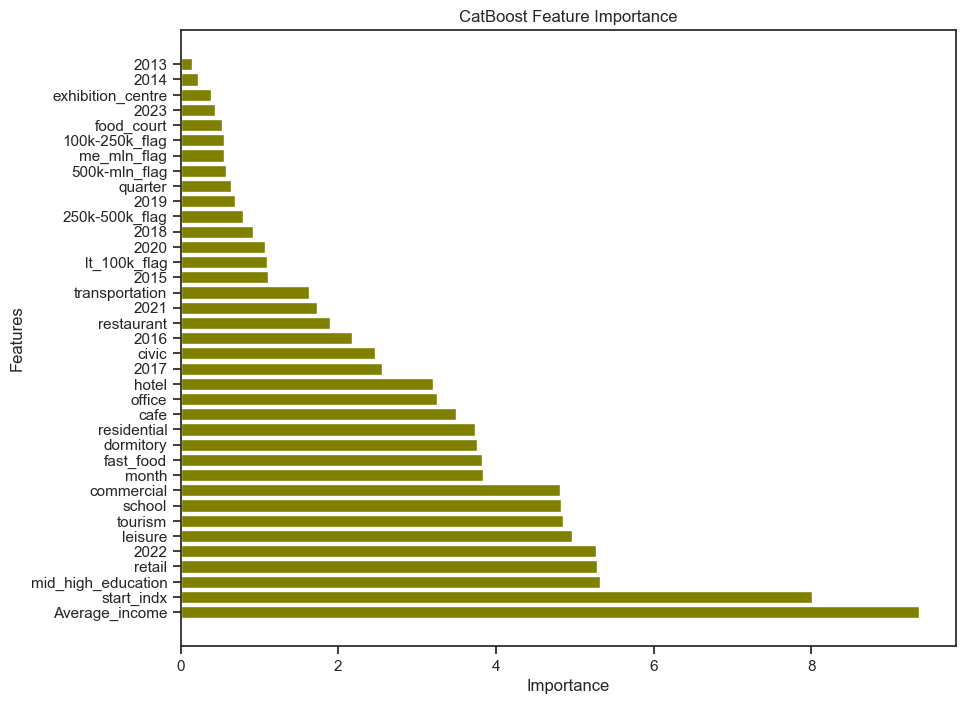

In [71]:
feature_importances = cbr.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_names = [X.columns[i] for i in sorted_indices]

plt.figure(figsize=(10,8))

plt.barh(range(len(feature_importances)), feature_importances[sorted_indices], color='olive')
plt.yticks(range(len(feature_importances)), sorted_feature_names)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('CatBoost Feature Importance')
plt.show()

## Going to go with basic model with selected features

In [72]:
sorted_feature_names = sorted_feature_names[:25]

In [73]:
cbr = CatBoostRegressor(
    loss_function='RMSE',
    early_stopping_rounds=100,
    max_depth=6
)

cbr.fit(
    X_train[sorted_feature_names],
    y_train,
    eval_set=(X_test[sorted_feature_names], y_test),
    plot=True
)


cbr.fit(X_train[sorted_feature_names], y_train, eval_set=(X_test[sorted_feature_names], y_test))
train_cbr = cbr.predict(X_train[sorted_feature_names])
test_cbr = cbr.predict(X_test[sorted_feature_names])
results = pd.concat([results, evaluation(test_cbr, train_cbr, 'cbr_important_features')], axis=0)
print(results)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.065623
0:	learn: 1623143.8459627	test: 1610166.9354027	best: 1610166.9354027 (0)	total: 1.76ms	remaining: 1.76s
1:	learn: 1596839.7271486	test: 1585398.8953582	best: 1585398.8953582 (1)	total: 3.2ms	remaining: 1.6s
2:	learn: 1574048.4457563	test: 1564329.6096673	best: 1564329.6096673 (2)	total: 4.28ms	remaining: 1.42s
3:	learn: 1552138.4208152	test: 1543575.8471504	best: 1543575.8471504 (3)	total: 5.26ms	remaining: 1.31s
4:	learn: 1535359.5520281	test: 1528223.8134010	best: 1528223.8134010 (4)	total: 6.17ms	remaining: 1.23s
5:	learn: 1518442.2255847	test: 1512470.2922420	best: 1512470.2922420 (5)	total: 7.15ms	remaining: 1.19s
6:	learn: 1503194.7385688	test: 1497921.1010338	best: 1497921.1010338 (6)	total: 8.58ms	remaining: 1.22s
7:	learn: 1487570.2973462	test: 1481946.4012926	best: 1481946.4012926 (7)	total: 9.89ms	remaining: 1.23s
8:	learn: 1473490.5051059	test: 1467857.7762016	best: 1467857.7762016 (8)	total: 11.6ms	remaining: 1.27s
9:	learn: 1461512.5681747	t

CBR on CV

In [74]:
cbr = CatBoostRegressor(
    loss_function='RMSE',
    early_stopping_rounds=100,
    learning_rate=0.3,
    max_depth=6
)
cv_metrics_counter(cbr, sorted_feature_names)

0:	learn: 1541971.9487302	total: 2.8ms	remaining: 2.8s
1:	learn: 1469447.4754011	total: 3.81ms	remaining: 1.9s
2:	learn: 1416193.0081029	total: 4.79ms	remaining: 1.59s
3:	learn: 1369080.8283112	total: 5.74ms	remaining: 1.43s
4:	learn: 1335947.0176522	total: 6.88ms	remaining: 1.37s
5:	learn: 1303607.7949567	total: 8.02ms	remaining: 1.33s
6:	learn: 1288222.2042134	total: 8.87ms	remaining: 1.26s
7:	learn: 1269368.8909458	total: 9.78ms	remaining: 1.21s
8:	learn: 1251158.6877470	total: 10.6ms	remaining: 1.17s
9:	learn: 1233146.3873451	total: 11.5ms	remaining: 1.14s
10:	learn: 1223360.8549492	total: 12.3ms	remaining: 1.11s
11:	learn: 1197953.8851647	total: 13.1ms	remaining: 1.08s
12:	learn: 1184650.7932312	total: 14ms	remaining: 1.06s
13:	learn: 1171666.5038722	total: 15ms	remaining: 1.06s
14:	learn: 1158284.8071557	total: 16ms	remaining: 1.05s
15:	learn: 1135806.5267403	total: 17.1ms	remaining: 1.05s
16:	learn: 1126531.5687023	total: 18.1ms	remaining: 1.05s
17:	learn: 1116626.2221709	total:

In [75]:
results

model           mae           mse      mape  \
0                    lasso_test  1.031537e+06  1.713662e+12  0.491492   
1                   lasso_train  1.043705e+06  1.739872e+12  0.869976   
0                    ridge_test  1.031493e+06  1.713389e+12  0.492370   
1                   ridge_train  1.043826e+06  1.740001e+12  0.872585   
0                cbr_basic_test  4.166344e+05  3.530933e+11  0.203038   
1               cbr_basic_train  2.860944e+05  1.483525e+11  0.174539   
0                cbr_tuned_test  3.660773e+05  2.944019e+11  0.172467   
1               cbr_tuned_train  8.214039e+04  1.219085e+10  0.044578   
0   cbr_important_features_test  4.280834e+05  3.698113e+11  0.201691   
1  cbr_important_features_train  2.885178e+05  1.521576e+11  0.239892   

        R^2  
0  0.359661  
1  0.360276  
0  0.359763  
1  0.360228  
0  0.868061  
1  0.945453  
0  0.889992  
1  0.995518  
0  0.861814  
1  0.944054

## XGBoost

In [76]:
xgboost = xgb.XGBRegressor(
    max_depth=6,
    learning_rate=0.3,
    # n_estimators=100,
    # objective='reg:squarederror'
)

xgboost.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=100,
    eval_metric='rmse'
)

train_xgb = xgboost.predict(X_train)
test_xgb = xgboost.predict(X_test)
results = pd.concat([results, evaluation(test_xgb, train_xgb, 'basic_xgb')], axis=0)
print(results)

[0]	validation_0-rmse:2891064.13514
[1]	validation_0-rmse:2219157.43779
[2]	validation_0-rmse:1781356.05327
[3]	validation_0-rmse:1507413.99907
[4]	validation_0-rmse:1332759.47530
[5]	validation_0-rmse:1236079.19445
[6]	validation_0-rmse:1175382.99680
[7]	validation_0-rmse:1138543.32003
[8]	validation_0-rmse:1104128.48438
[9]	validation_0-rmse:1082593.14908
[10]	validation_0-rmse:1054004.60951
[11]	validation_0-rmse:1035551.66927
[12]	validation_0-rmse:1002280.75669
[13]	validation_0-rmse:996304.34151
[14]	validation_0-rmse:989483.44406
[15]	validation_0-rmse:981072.68340
[16]	validation_0-rmse:970542.47579
[17]	validation_0-rmse:945946.43869
[18]	validation_0-rmse:922219.62395
[19]	validation_0-rmse:911895.54862
[20]	validation_0-rmse:891497.61488
[21]	validation_0-rmse:881895.86084
[22]	validation_0-rmse:862085.44783
[23]	validation_0-rmse:860264.41914
[24]	validation_0-rmse:854769.21827
[25]	validation_0-rmse:839628.91792
[26]	validation_0-rmse:825740.73486
[27]	validation_0-rmse:82

/Users/nikitasenyatkin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/nikitasenyatkin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[49]	validation_0-rmse:698532.44947
[50]	validation_0-rmse:693977.70064
[51]	validation_0-rmse:686905.57065
[52]	validation_0-rmse:686133.97465
[53]	validation_0-rmse:684589.84961
[54]	validation_0-rmse:679662.30948
[55]	validation_0-rmse:676764.57606
[56]	validation_0-rmse:673530.06608
[57]	validation_0-rmse:669773.40325
[58]	validation_0-rmse:668768.87382
[59]	validation_0-rmse:667707.67813
[60]	validation_0-rmse:667003.60342
[61]	validation_0-rmse:664292.14167
[62]	validation_0-rmse:662255.55098
[63]	validation_0-rmse:661292.49699
[64]	validation_0-rmse:658884.33336
[65]	validation_0-rmse:656564.85319
[66]	validation_0-rmse:656131.84407
[67]	validation_0-rmse:654009.71633
[68]	validation_0-rmse:651426.14976
[69]	validation_0-rmse:650448.81929
[70]	validation_0-rmse:648509.27490
[71]	validation_0-rmse:645895.19437
[72]	validation_0-rmse:644191.93033
[73]	validation_0-rmse:641613.17505
[74]	validation_0-rmse:641127.29404
[75]	validation_0-rmse:641080.62445
[76]	validation_0-rmse:63939

In [77]:
xgboost = xgb.XGBRegressor(
    max_depth=6,
    learning_rate=0.3,
    # n_estimators=100,
    # objective='reg:squarederror'
)

cv_metrics_counter(xgboost)

Mean MAPE: 34.83%
Mean MAE: 474966.53
Mean MSE: 438363036867.98
Mean R-squared: 0.84


## Tune XGB

In [78]:
# Define the XGBoost model
model = xgb.sklearn.XGBRegressor()

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.3, 0.01, 0.001],
    'n_estimators': [100, 500, 1000]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_


Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [79]:
# Define the XGBoost model with the best parameters
model = xgb.sklearn.XGBRegressor(**best_params)

cv_metrics_counter(model)

Mean MAPE: 23.40%
Mean MAE: 415588.28
Mean MSE: 356985133663.20
Mean R-squared: 0.87


In [80]:
# Train the XGBoost model with the best hyperparameters
xgb_model = xgb.sklearn.XGBRegressor(**best_params)
xgb_model.fit(X_train, y_train)

test_xgb = xgb_model.predict(X_test)
train_xgb = xgb_model.predict(X_train)

results = pd.concat([results, evaluation(test_xgb, train_xgb, 'tuned_xgb')], axis=0)
print(results)

                          model           mae           mse      mape  \
0                    lasso_test  1.031537e+06  1.713662e+12  0.491492   
1                   lasso_train  1.043705e+06  1.739872e+12  0.869976   
0                    ridge_test  1.031493e+06  1.713389e+12  0.492370   
1                   ridge_train  1.043826e+06  1.740001e+12  0.872585   
0                cbr_basic_test  4.166344e+05  3.530933e+11  0.203038   
1               cbr_basic_train  2.860944e+05  1.483525e+11  0.174539   
0                cbr_tuned_test  3.660773e+05  2.944019e+11  0.172467   
1               cbr_tuned_train  8.214039e+04  1.219085e+10  0.044578   
0   cbr_important_features_test  4.280834e+05  3.698113e+11  0.201691   
1  cbr_important_features_train  2.885178e+05  1.521576e+11  0.239892   
0                basic_xgb_test  4.408812e+05  3.821527e+11  0.205569   
1               basic_xgb_train  2.003233e+05  7.447781e+10  0.090979   
0                tuned_xgb_test  3.681923e+05  3.02

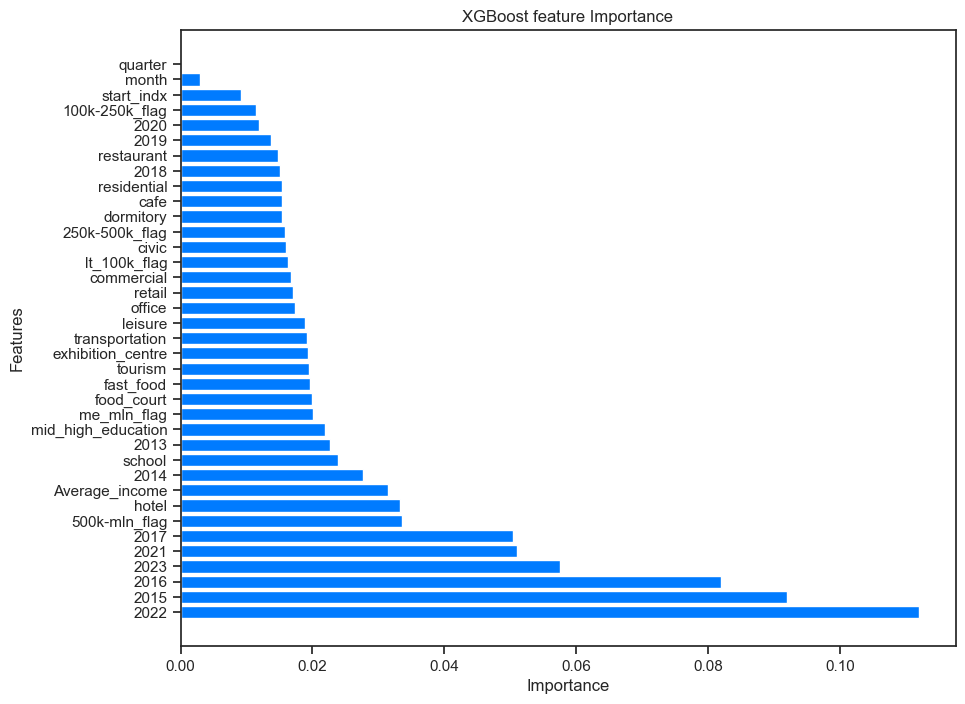

In [81]:
importance_scores = xgb_model.feature_importances_
feature_importance = list(zip(X_train.columns, importance_scores))
feature_importance_sorted = sorted(feature_importance, key=lambda x: x[1], reverse=True)
features_sorted, scores_sorted = zip(*feature_importance_sorted)

plt.figure(figsize=(10,8))

plt.barh(range(len(features_sorted)), scores_sorted)
plt.yticks(range(len(features_sorted)), features_sorted)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("XGBoost feature Importance")
plt.show()



In [82]:
xgb_important_features = list(features_sorted)[:35]

In [83]:
# Define the XGBoost model with the best parameters
model = xgb.sklearn.XGBRegressor(**best_params)

cv_metrics_counter(model, xgb_important_features)

Mean MAPE: 30.49%
Mean MAE: 454141.56
Mean MSE: 421280034767.38
Mean R-squared: 0.85


## Prediction

In [84]:
#Our model
cbr = CatBoostRegressor(
    loss_function='RMSE',
    learning_rate=0.3,
    early_stopping_rounds=100,
    max_depth=6
)

cbr.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test)
)


0:	learn: 1544230.7871579	test: 1531249.7580112	best: 1531249.7580112 (0)	total: 3ms	remaining: 2.99s
1:	learn: 1475465.1043833	test: 1465972.8997923	best: 1465972.8997923 (1)	total: 4.76ms	remaining: 2.37s
2:	learn: 1410407.8146939	test: 1401790.7363353	best: 1401790.7363353 (2)	total: 6.48ms	remaining: 2.15s
3:	learn: 1371126.1987486	test: 1363635.3350713	best: 1363635.3350713 (3)	total: 8.64ms	remaining: 2.15s
4:	learn: 1334860.7001005	test: 1336659.8250588	best: 1336659.8250588 (4)	total: 10.7ms	remaining: 2.13s
5:	learn: 1310740.4285883	test: 1310470.0142240	best: 1310470.0142240 (5)	total: 12.9ms	remaining: 2.13s
6:	learn: 1291716.7227034	test: 1292971.6491040	best: 1292971.6491040 (6)	total: 14.4ms	remaining: 2.04s
7:	learn: 1278269.3119856	test: 1282103.3422521	best: 1282103.3422521 (7)	total: 15.7ms	remaining: 1.95s
8:	learn: 1264534.7588444	test: 1269082.8196794	best: 1269082.8196794 (8)	total: 17ms	remaining: 1.87s
9:	learn: 1242596.2325978	test: 1253104.5213040	best: 125310

In the official franchise table there are wide amount of the cities that are opened to franchising https://docs.google.com/spreadsheets/d/1yLS46DM-8WesGsvrkw_KvgkTiJN9V5PxwKdK2s_dEZ0/edit#gid=1153462500

let's take Острогожск with coords: 50.860154, 39.064355

creation a function fo parse

In [85]:
api = overpy.Overpass()
attributes = [
    {'building':'apartments'},
    {'building':'dormitory'},
    {'building':'hotel'},
    {'building':'residential'}, #sub from it number of appartments
    {'building':'commercial'}, #all commerce
    {'building':'office'}, #sub from commercial this num
    {'building':'retail'}, #sub from commercial this num
    {'building':'civic'},
    {'building':'college'}, #sub from civic
    {'building':'school'}, #sub from civis
    {'building':'transportation'}, #sub from civic
    {'building':'university'}, #sub from civic
    {'building':'stadium'}, #check whether inside of civic
    {'building':'sports_hall'},
    {'building':'pavilion'},
    {'leisure':'adult_gaming_centre'}, #sum all leasures
    {'leisure':'fitness_centre'},
    {'leisure':'park'},
    {'leisure':'sauna'},
    {'leisure':'hackerspace'},
    {'amenity':'bar'},
    {'amenity':'fast_food'},
    {'amenity':'cafe'},
    {'amenity':'food_court'},
    {'amenity':'restaurant'},
    {'amenity':'cinema'},
    {'amenity':'exhibition_centre'},
    {'tourism':'attraction'}, #sum all tourism
    {'tourism':'gallery'},
    {'tourism':'museum'},
    {'tourism':'zoo'},
    {'tourism':'yes'},
    {'tourism':'picnic_site'}
]
def parser(coords:list, range:int):
    dct = {}
    lat = coords[0]
    long = coords[1]
    
    for i in attributes:
        for key, value in i.items():
            if value == 'apartments':
                query1 = f'''
                way["{key}"="{value}"]["building:levels"~"^([0-4])$"](around:{range}, {lat}, {long});
                out;
                '''
                query2 = f'''
                way["{key}"="{value}"]["building:levels"~"^([5-9])$"](around:{range}, {lat}, {long});
                out;
                '''
                query3 = f'''
                way["{key}"="{value}"]["building:levels"~"^1[0-4]$"](around:{range}, {lat}, {long});
                out;
                '''
                query4 = f'''
                way["{key}"="{value}"]["building:levels"~"^(1[5-9]|[2-9][0-9]|[1-9][0-9][0-9])$"](around:{range}, {lat}, {long});
                out;
                '''
                res1 = api.query(query1)
                cnt1 = len(res1.ways)
                dct[value+'<5lvl'] = cnt1
                res2 = api.query(query2)
                cnt2 = len(res2.ways)
                dct[value+'>=5lvl<10'] = cnt2
                res3 = api.query(query3)
                cnt3 = len(res3.ways)
                dct[value+'>=10<15'] = cnt3
                res4 = api.query(query4)
                cnt4 = len(res4.ways)
                dct[value+'>=15'] = cnt4
            else:
                query = f'''
                way["{key}"="{value}"](around:{range}, {lat}, {long});
                out;
                '''
                result = api.query(query)
                cnt = len(result.ways)
                dct[value] = cnt

    return dct


Function that creates df of features

In [86]:
def filler_w_parse_data(city, coords):
    #for parse to new features
    if city == "Москва" or city == "Санкт-Петербург":
        parse_data = parser(coords, 2500)
    else:
        parse_data = parser(coords, 4000)
    df = pd.DataFrame.from_dict(parse_data, orient='index').T
        
    return df

Function that expands df for several months prediction

In [152]:
def expand(df, num_rows):
    expanded_dfs = []
    for i in range(1, num_rows+1):
        expanded_df = df.copy()
        expanded_df['start_indx'] = i
        expanded_df['month'] = (df['month'].iloc[0] + i - 1) % 12 + 1
        expanded_dfs.append(expanded_df)
    
    return pd.concat(expanded_dfs, ignore_index=True)

In [150]:
def infer(city: str, coords: list, number_of_months: int)->pd.DataFrame:
    """
    city - city;
    coords - coordinates of the point;
    number_of_months - number of months from 0 to 12 to create prediction;
    population - city population TBD;
    avg_wage - wage of the region TBD
    """
    if number_of_months >12 or number_of_months<1:
        return print("number_of_months should be from 1 to 12")
    #df creation
    df = filler_w_parse_data(city, coords)
    df['city'] = city
    df['leisure'] = df['adult_gaming_centre'] + df['fitness_centre'] + df['park'] + df['sauna'] + df['hackerspace']+df['cinema']
    df['tourism'] = df['attraction'] + df['gallery'] + df['museum'] + df['zoo'] + df['picnic_site']
    df['mid_high_education'] = df['college'] + df['university']
    df['civic'] = df['civic'] + df['transportation']
    current_month = dt.datetime.now().month
    df = pd.merge(df, cities_info, left_on='city', right_on='City', how='inner')
    df['month'] = current_month
    df['start_indx'] = 0
    df['quarter'] = df['month']//3+1

    COLS = TRAIN_COLUMNS.copy()
    COLS.remove('year')
    df = df[COLS + LOCATION_COLUMNS_TRAIN]

    #dummies of the years
    for i in range(2013,2024):
        if i == 2023:
            df[str(i)] = 1
        else:
            df[str(i)] = 0
    
    #df expansion
    df = expand(df, number_of_months)
    df[SCALE_COLUMNS + LOCATION_COLUMNS_TRAIN] = scaler.transform(df[SCALE_COLUMNS + LOCATION_COLUMNS_TRAIN])
    #prediction
    predictions = cbr.predict(df)

    for i in range(1,number_of_months+1):
        print(f'Prediction for month{i}: {round(predictions[i-1],2)}')
    print(f'For city {city} total revenue for {number_of_months} months is {round(sum(predictions),2)}')
    


In [145]:
TRAIN_COLUMNS

['year',
 'month',
 'start_indx',
 'Average_income',
 'me_mln_flag',
 '500k-mln_flag',
 '250k-500k_flag',
 '100k-250k_flag',
 'lt_100k_flag',
 'quarter']

In [155]:
a= infer("Острогожск", [50.860154, 39.064355], 12)


Prediction for month1: 1029285.06
Prediction for month2: 1738233.1
Prediction for month3: 2019028.53
Prediction for month4: 1925796.52
Prediction for month5: 1880738.88
Prediction for month6: 1748833.64
Prediction for month7: 1898694.28
Prediction for month8: 1986823.01
Prediction for month9: 1745223.89
Prediction for month10: 2109482.15
Prediction for month11: 2517650.71
Prediction for month12: 2965997.04
For city Острогожск total revenue for 12 months is 23565786.8
